# phase_locking_fr_power_relations.ipynb

In [2]:
import sys
import os
import glob
from time import time
from collections import OrderedDict
from importlib import reload
from glob import glob

import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['xtick.labelsize'] = 'small'
mpl.rcParams['ytick.labelsize'] = 'small'
mpl.rcParams['axes.labelsize'] = 'small'
mpl.rcParams['axes.titlesize'] = 'small'
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.titlesize'] = 'small'
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 0.8 

import mne
import neurodsp
from ptsa.data.TimeSeriesX import TimeSeries 

sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects/unit_activity_and_hpc_theta')
import data_io as dio
import array_operations as aop
import spectral_processing as spp
import manning_utils
import manning_analysis
import phase_locking
from eeg_plotting import plot_trace, plot_trace2

In [407]:
import itertools
import statsmodels.api as sm
import astropy.stats.circstats as circstats
from math import floor, ceil
import random

In [4]:
# Params.
bands = OrderedDict([('sub_delta', [0.5, 2]),
                     ('delta', [1, 4]),
                     ('low_theta', [2, 8]),
                     ('high_theta', [4, 16]),
                     ('alpha_beta', [8, 32])])
band_names = list(bands.keys())
bands_fancy = OrderedDict([('sub_delta', 'Sub-delta (0.5-2 Hz)'),
                           ('delta', 'Delta (1-4 Hz)'),
                           ('low_theta', 'Low theta (2-8 Hz)'),
                           ('high_theta', 'High theta (4-16 Hz)'),
                           ('alpha_beta', 'Alpha-beta (8-32 Hz)')])
bands_fancy2 = OrderedDict([('sub_delta', 'Sub-delta'),
                            ('delta', 'Delta'),
                            ('low_theta', 'Low theta'),
                            ('high_theta', 'High theta'),
                            ('alpha_beta', 'Alpha-beta')])
rois = ['hpc', 'amy', 'ec', 'phg', 'ctx']
sessions = ['U387_ses3', 'U369_env1', 'U372_ses2', 'U390_ses3', 
            'U369_env2', 'U373_ses1', 'U387_ses1', 'U380_ses2', 
            'U393_ses2', 'U395_ses2', 'U384_ses3', 'U385_ses4', 
            'U371_env2', 'U371_env3']
sessions = np.sort(sessions)

interp_spikes = False
notch_freqs = [60, 120]
phase_type = 'extrema2'
mask_type = None

In [5]:
# Load all cross-electrode files into a single dataframe.
upl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                              '*_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_timelag-2to2sec-step10ms_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(upl_files)))

upl_df = dio.open_pickle(upl_files[0])
for f in upl_files[1:]:
    upl_df = upl_df.append(dio.open_pickle(f))
upl_df.reset_index(drop=True, inplace=True)
upl_df['locked_band'] = upl_df.locked_band.astype('category').cat.reorder_categories(band_names, ordered=True)
upl_df['unit_roi2'] = upl_df.unit_roi2.astype('category').cat.reorder_categories(rois, ordered=True)
upl_df['lfp_roi2'] = upl_df.lfp_roi2.astype('category').cat.reorder_categories(rois, ordered=True)

Found 14 files


In [547]:
upl_files = glob(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking', 
                              '*_crosselec_phaselock_byunit_df_fr_power_diffs_notch60-120_nospikeinterp_phase-extrema2_nomask_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'))
print('Found {} files'.format(len(upl_files)))

upl_df = dio.open_pickle(upl_files[0])
for f in upl_files[1:]:
    upl_df = upl_df.append(dio.open_pickle(f))

Found 14 files


In [548]:
upl_df.shape, upl_df.columns

((498, 22),
 Index(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 'unit_hem',
        'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 'unit_fr', 'unit_nspikes',
        'pl_diffs_fr', 'pl_diffs_pow_locked', 'pl_diffs_pow_nonlocked',
        'pl_diffs_fr_sign', 'pl_diffs_pow_locked_sign',
        'pl_diffs_pow_nonlocked_sign', 'pl_diffs_fr_pval',
        'pl_diffs_pow_locked_pval', 'pl_diffs_pow_nonlocked_pval',
        'pl_diffs_fr_sig', 'pl_diffs_pow_locked_sig',
        'pl_diffs_pow_nonlocked_sig'],
       dtype='object'))

In [549]:
(upl_df
 .query("(unit_roi2!='hpc')")
 .groupby(['lfp_is_hpc'])
 .agg({'subj_sess_unit': len,
       'pl_diffs_fr_sig': np.mean,
       'pl_diffs_pow_locked_sig': np.mean,
       'pl_diffs_pow_nonlocked_sig': np.mean}))

,subj_sess_unit,pl_diffs_fr_sig,pl_diffs_pow_locked_sig,pl_diffs_pow_nonlocked_sig
lfp_is_hpc,,,,
0,265,0.392453,0.724528,0.494340
1,146,0.410959,0.657534,0.589041


In [550]:
(upl_df
 .query("(unit_roi2!='hpc')")
 .groupby(['lfp_is_hpc', 'pl_diffs_fr_sign'])
 .agg({'subj_sess_unit': len,
       'pl_diffs_fr': np.mean,
       'pl_diffs_fr_sig': [np.mean, lambda x: np.mean(x) * len(x)]}))

subj_sess_unit pl_diffs_fr pl_diffs_fr_sig  \
                                       len        mean            mean   
lfp_is_hpc pl_diffs_fr_sign                                              
0          -1.0                        147   -0.025719        0.380952   
            1.0                        118    0.040215        0.406780   
1          -1.0                         64   -0.021798        0.328125   
            1.0                         82    0.036883        0.475610   

                                      
                            <lambda>  
lfp_is_hpc pl_diffs_fr_sign           
0          -1.0                 56.0  
            1.0                 48.0  
1          -1.0                 21.0  
            1.0                 39.0

In [551]:
(upl_df
 .query("(unit_roi2!='hpc')")
 .groupby(['lfp_is_hpc', 'pl_diffs_pow_locked_sign'])
 .agg({'subj_sess_unit': len,
       'pl_diffs_pow_locked': np.mean,
       'pl_diffs_pow_locked_sig': [np.mean, lambda x: np.mean(x) * len(x)]}))

subj_sess_unit pl_diffs_pow_locked  \
                                               len                mean   
lfp_is_hpc pl_diffs_pow_locked_sign                                      
0          -1.0                                 16           -0.013145   
            1.0                                249            0.070871   
1          -1.0                                  8           -0.013511   
            1.0                                138            0.055296   

                                    pl_diffs_pow_locked_sig           
                                                       mean <lambda>  
lfp_is_hpc pl_diffs_pow_locked_sign                                   
0          -1.0                                    0.000000      0.0  
            1.0                                    0.771084    192.0  
1          -1.0                                    0.125000      1.0  
            1.0                                    0.688406     95.0

In [552]:
(upl_df
 .query("(unit_roi2!='hpc')")
 .groupby(['lfp_is_hpc', 'pl_diffs_pow_nonlocked_sign'])
 .agg({'subj_sess_unit': len,
       'pl_diffs_pow_nonlocked': np.mean,
       'pl_diffs_pow_nonlocked_sig': [np.mean, lambda x: np.mean(x) * len(x)]}))

subj_sess_unit pl_diffs_pow_nonlocked  \
                                                  len                   mean   
lfp_is_hpc pl_diffs_pow_nonlocked_sign                                         
0          -1.0                                    55              -0.011901   
            1.0                                   210               0.041937   
1          -1.0                                    23              -0.008050   
            1.0                                   123               0.041132   

                                       pl_diffs_pow_nonlocked_sig           
                                                             mean <lambda>  
lfp_is_hpc pl_diffs_pow_nonlocked_sign                                      
0          -1.0                                          0.181818     10.0  
            1.0                                          0.576190    121.0  
1          -1.0                                          0.043478      1.0  
            1.0                                          0.691057     85.0

In [589]:
(upl_df
 .groupby(['unit_roi2', 'lfp_is_hpc'])
 .agg({'subj_sess_unit': len,
       'pl_diffs_fr_sig': np.mean,
       'pl_diffs_pow_locked_sig': np.mean,
       'pl_diffs_pow_nonlocked_sig': np.mean}))

subj_sess_unit  pl_diffs_fr_sig  \
unit_roi2 lfp_is_hpc                                    
amy       0                       82         0.353659   
          1                       78         0.435897   
ctx       0                      112         0.526786   
          1                       26         0.423077   
ec        0                       32         0.218750   
          1                       28         0.357143   
hpc       1                       87         0.413793   
phg       0                       39         0.230769   
          1                       14         0.357143   

                      pl_diffs_pow_locked_sig  pl_diffs_pow_nonlocked_sig  
unit_roi2 lfp_is_hpc                                                       
amy       0                          0.719512                    0.548780  
          1                          0.730769                    0.628205  
ctx       0                          0.794643                    0.535714  
          1                          0.538462                    0.500000  
ec        0                          0.625000                    0.500000  
          1                          0.714286                    0.642857  
hpc       1                          0.827586                    0.655172  
phg       0                          0.615385                    0.256410  
          1                          0.357143                    0.428571

In [590]:
upl_df['pl_diffs_pow_locked-nonlocked'] = upl_df.pl_diffs_pow_locked - upl_df.pl_diffs_pow_nonlocked

In [596]:
(upl_df
 .query("(unit_roi2!='hpc')")
 .groupby(['lfp_is_hpc', 'pl_diffs_pow_locked_sig', 'pl_diffs_pow_nonlocked_sig'])
 .agg({'subj_sess_unit': len, 'pl_diffs_pow_locked-nonlocked': np.mean}))

subj_sess_unit  \
lfp_is_hpc pl_diffs_pow_locked_sig pl_diffs_pow_nonlocked_sig                   
0          False                   False                                   55   
                                   True                                    18   
           True                    False                                   79   
                                   True                                   113   
1          False                   False                                   35   
                                   True                                    15   
           True                    False                                   25   
                                   True                                    71   

                                                               pl_diffs_pow_locked-nonlocked  
lfp_is_hpc pl_diffs_pow_locked_sig pl_diffs_pow_nonlocked_sig                                 
0          False                   False                                            0.006048  
                                   True                                             0.014972  
           True                    False                                            0.044053  
                                   True                                             0.046035  
1          False                   False                                            0.005786  
                                   True                                            -0.005975  
           True                    False                                            0.030288  
                                   True                                             0.025049

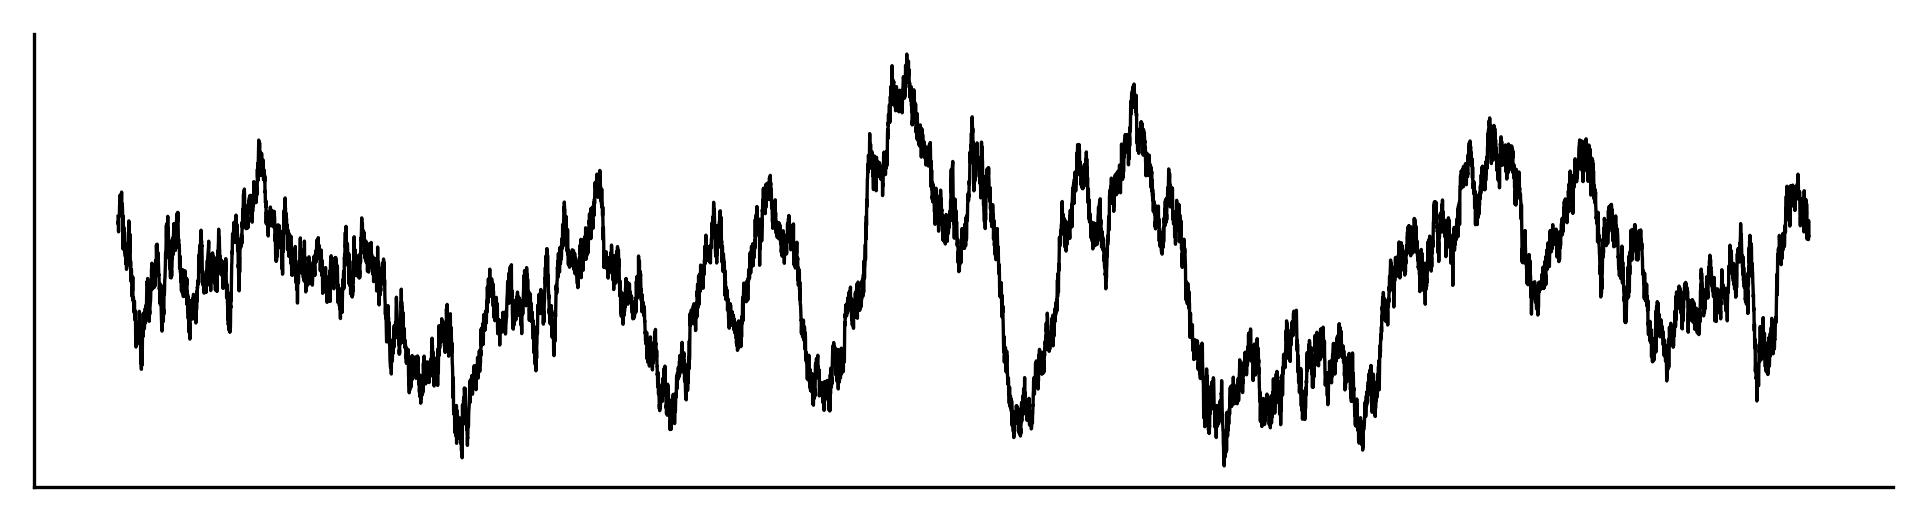

In [730]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=300)
plt.plot(lfp_preproc[1, 15000:25000], color='k')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/figs', 'sample_lfp_trace.png'), dpi=300, transparent=True)

In [595]:
stats.wilcoxon(upl_df.query("(unit_roi2!='hpc') & (pl_diffs_pow_locked_sig==True) & (pl_diffs_pow_nonlocked_sig==True) & (lfp_is_hpc==True)").pl_diffs_pow_locked,
               upl_df.query("(unit_roi2!='hpc') & (pl_diffs_pow_locked_sig==True) & (pl_diffs_pow_nonlocked_sig==True) & (lfp_is_hpc==True)").pl_diffs_pow_nonlocked)

WilcoxonResult(statistic=209.0, pvalue=9.057288960382383e-10)

In [795]:
def get_cycle_durs(phase, bands, sampling_rate=2000):
    """Return an n_chan x n_timepoints array of cycle durations for each band."""
    durs = OrderedDict()
    cycle_durs = OrderedDict()
    for band_name in band_names:
        xinds, yinds = phase[band_name]['inds']
        cycle_durs_samples = []
        cycle_durs_hz = []
        n_timepoints = phase[band_name]['phase'].shape[1]
        v = np.arange(n_timepoints)
        for xind in np.unique(xinds):
            yinds_ = yinds[xinds==xind]
            split_arr = np.split(v, yinds_)
            cycle_durs_samples.append(np.array([len(arr) for arr in split_arr]))
            cycle_durs_hz.append(np.array([sampling_rate / len(arr) for arr in split_arr]))
        cycle_durs[band_name] = OrderedDict()
        cycle_durs[band_name]['samples'] = cycle_durs_samples
        cycle_durs[band_name]['hz'] = cycle_durs_hz
        durs[band_name] = np.array([np.repeat(cycle_durs[band_name]['hz'][ichan], cycle_durs[band_name]['samples'][ichan]) 
                                    for ichan in range(len(cycle_durs[band_name]['hz']))])
    return durs, cycle_durs

In [796]:
durs, cycle_durs = get_cycle_durs(phase, bands)

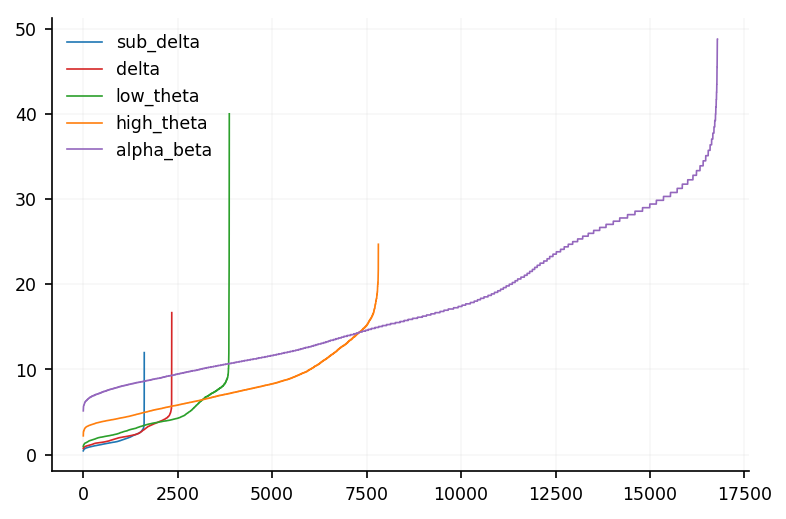

In [798]:
for band_name in band_names:
    plt.plot(np.sort(cycle_durs[band_name]['hz'][0]), label=band_name)
plt.legend(loc=2)

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b5c3b0d3978>],
       dtype=object))

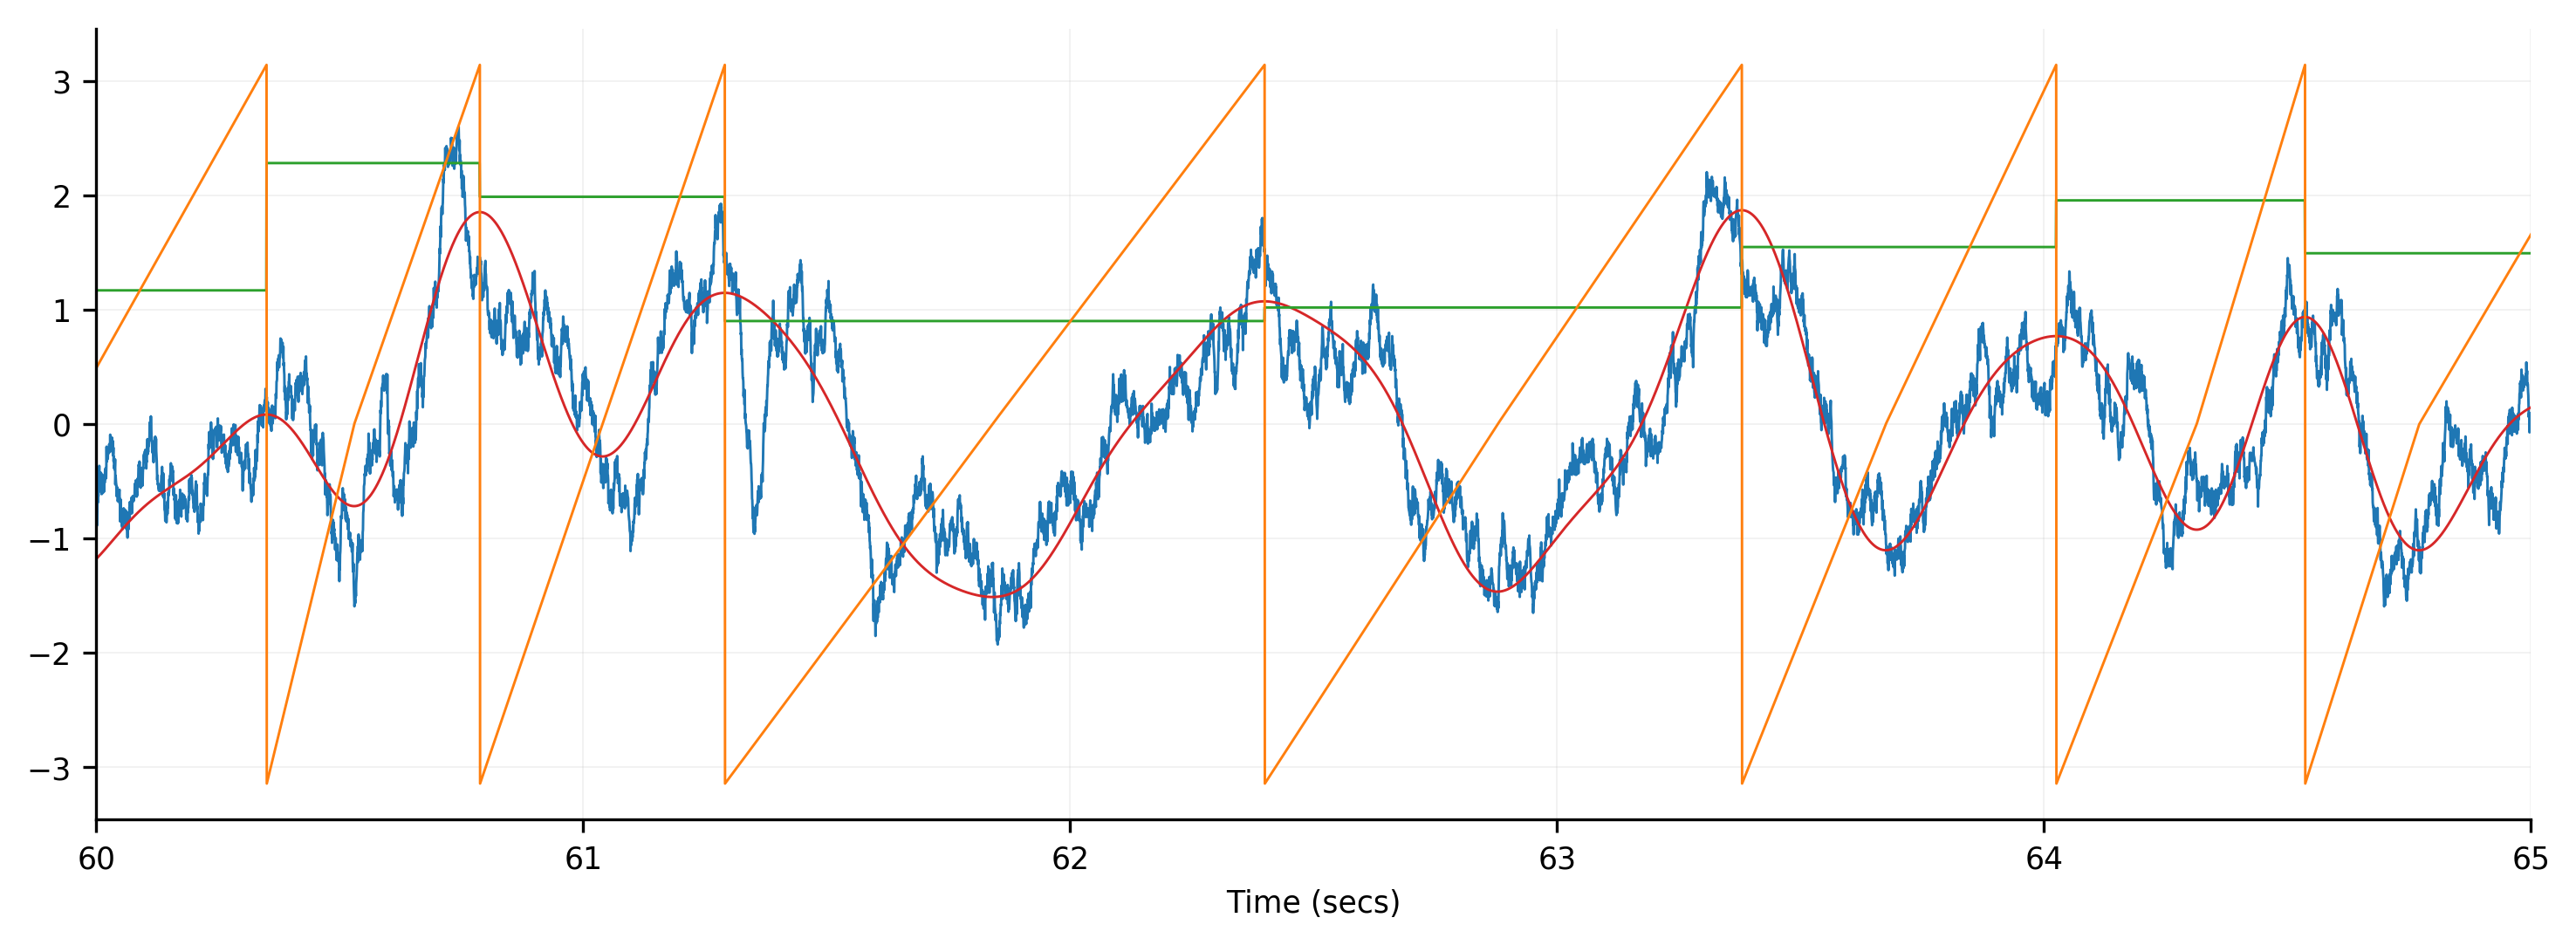

In [786]:
plot_trace(np.vstack((stats.zscore(lfp_preproc[:1, :], axis=1), lfp_filt['sub_delta'][:1, :], durs['sub_delta'][:1, :], phase['sub_delta']['phase'][:1, :])), start=60, duration=5)

In [815]:
# What percent of cycles are outside of the band?
for band_name, pass_band in bands.items():
    print(band_name, 
          np.median([np.sum(cycle_durs[band_name]['hz'][x] < pass_band[0]) / len(cycle_durs[band_name]['hz'][x]) for x in range(len(cycle_durs[band_name]['hz']))]),
          np.median([np.sum(cycle_durs[band_name]['hz'][x] > pass_band[1]) / len(cycle_durs[band_name]['hz'][x]) for x in range(len(cycle_durs[band_name]['hz']))]))

sub_delta 0.0011255013136126754 0.31222140890000427
delta 0.02599869101511687 0.1064257338798795
low_theta 0.11568845519121762 0.03785919238706652
high_theta 0.05984169842355674 0.05802109716377428
alpha_beta 0.01449615797600794 0.06856500898501613


In [811]:
len(cycle_durs[band_name]['hz'])

58

In [ ]:
def calc_cross_electrode_phase_locking_mrl_ctx(subj_sess,
                                           bands=None,
                                           interp_spikes=True,
                                           notch_freqs=[60, 120],
                                           zscore_lfp=True,
                                           zscore_power=True,
                                           phase_type='extrema2', # troughs, peaks, or hilbert
                                           power_percentile=25,
                                           osc_length=3,
                                           mask_type=None,
                                           ctx_subset=True,
                                           n_bootstraps=1000,
                                           save_outputs=True,
                                           output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'):
    """Calculate phase-locking between each unit and each channel LFP, 
    for a given set of frequency bands.
    
    Returns
    -------
    pl_df : pd.DataFrame
        The cross-electrode phase-locking DataFrame (all unit-to-channel pairs).
    """
    if bands is None:
        bands = OrderedDict([('sub_delta', [0.5, 2]),
                             ('delta', [1, 4]),
                             ('low_theta', [2, 8]),
                             ('high_theta', [4, 16]),
                             ('alpha_beta', [8, 32])])
    band_names = list(bands.keys())
    
    # Get session info.
    subj_df = get_subj_df()
    
    # Load spikes.
    spikes, fr_df, clus_to_chan, chan_to_clus = load_spikes(subj_sess)
    units = fr_df.clus.tolist()
    
    # Load the raw LFP.
    ms_before = 2
    ms_after = 4
    lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                        subj_df=subj_df, 
                                                        notch_freqs=notch_freqs,
                                                        interpolate=interp_spikes,
                                                        session_spikes=spikes,
                                                        ms_before=ms_before,
                                                        ms_after=ms_after)
    del lfp_raw, spikes
    
    # Bandpass filter the LFP.
    lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
                                    bands=bands, 
                                    zscore_lfp=zscore_lfp)
    del lfp_preproc
    
    # Use a derivative test to identify troughs and peaks in the filtered 
    # LFP, then linearly interpolate phase between cycles.
    if phase_type == 'hilbert':
        phase_type_ = 'peaks'
    else:
        phase_type_ = phase_type
    
    phase = get_phase_bands(lfp_filt, 
                            bands=bands, 
                            find=phase_type_, 
                            lims=[-np.pi, np.pi])
        
    # Get Hilbert transform phase (instead of linearly interpolated phase).
    if phase_type == 'hilbert':
        for band_name, pass_band in bands.items():
            _, phase_hilbert = spp.get_hilbert(lfp_filt[band_name])
            phase[band_name]['phase'] = phase_hilbert
    del lfp_filt
    
    # Get phase mask.
    if mask_type is not None: 
        cycle_stats = dio.open_pickle(os.path.join('/scratch/dscho/phase_precession/data/cycle_stats',
                                                   '{}_cycle_stats_{}_{}powpct_{}osclength.pkl'
                                                   .format(subj_sess, phase_type_, power_percentile, osc_length)))
        mask = OrderedDict()
        for band_name, pass_band in bands.items():
            mask[band_name] = cycles_to_lfp(cycle_stats, category=mask_type, cycle_type=band_name)
    
    # Load the cross-electrode DataFrame.
    pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                           '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))
    
    # Restrict analyses to a subset of pairs.
    if ctx_subset:
        # Remove units with <250 spikes.
        pl_df = pl_df.loc[pl_df.unit_nspikes>249]
        # Remove units that don't have connections to HPC.
        keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
        pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))
        # Remove hippocampal units.
        pl_df = pl_df.query("(unit_roi2!='hpc')")
        # Remove inter-hemispheric pairs.
        pl_df = pl_df.loc[pl_df.same_hem==True]
        # Remove same-channel pairs.
        pl_df = pl_df.loc[pl_df.same_chan!=True]
        # Remove pairs with hippocampal LFPs or that are within the same microwire bundle.
        pl_df = pl_df.query("(lfp_is_hpc==False) & (same_hemroi==False)")

    pl_df = pl_df.reset_index(drop=True).copy()
    
    # Get phase and phase stats for each band.
    mrls = []
    for iunit in range(len(pl_df)):
        unit = pl_df.at[iunit, 'unit']
        lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
        spike_train = fr_df.at[unit, 'spikes']
        spike_train[:4000] = False
        spike_train[-4000:] = False
        mrls_ = []
        for band_name, pass_band in bands.items():
            if mask_type is None:
                spike_inds = np.where(spike_train)[0]
            else:
                spike_inds = np.where(mask[band_name][lfp_chan_ind, :] * spike_train)[0]
            spike_phases = phase[band_name]['phase'][lfp_chan_ind, spike_inds]
            if len(spike_phases) > 0:
                mrls_.append(circstats.circmoment(spike_phases)[1])
            else:
                mrls_.append(np.nan)
        mrls.append(np.array(mrls_))
    pl_df['mrls'] = mrls
    
    # Bootstrapping - Randomly shift the spike train n_bootstraps times and
    # recalc MRLs. Because a unit could be phase-locked at a short time
    # lag, permutations will shift the spike train by at least 2 secs.
    # IMPORTANTLY, each permutation shifts all spike trains by the same offset. 
    bs_mrls = []
    n_timepoints = len(spike_train)
    bs_offsets = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                           for _ in range(n_bootstraps)])
    for iunit in range(len(pl_df)):
        unit = pl_df.at[iunit, 'unit']
        lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
        spike_train = fr_df.at[unit, 'spikes']
        unit_bs_mrls = []
        for band_name, pass_band in bands.items(): 
            unit_bs_mrls_ = []
            for iperm in range(n_bootstraps):
                spike_train_shifted = np.roll(spike_train, bs_offsets[iperm])
                spike_train_shifted[:4000] = False
                spike_train_shifted[-4000:] = False
                if mask_type is None:
                    spike_inds = np.where(spike_train_shifted)[0]
                else:
                    spike_inds = np.where(mask[band_name][lfp_chan_ind, :] * spike_train_shifted)[0]
                spike_phases = phase[band_name]['phase'][lfp_chan_ind, spike_inds]
                unit_bs_mrls_.append(circstats.circmoment(spike_phases)[1])
            unit_bs_mrls.append(unit_bs_mrls_)
        bs_mrls.append(np.array(unit_bs_mrls))
    pl_df['bs_mrls'] = bs_mrls
    del phase
    
    # Get the mean MRL across unit->LFP pairs for unit->local
    # and unit->HPC connections, for each band.
    alpha = 0.05 / len(bands)
    upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi', 'lfp_roi', 
                             'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                             'unit_fr', 'unit_nspikes'])
                   .agg({'mrls': lambda x: tuple(np.mean(x)),
                         'bs_mrls': lambda x: tuple(np.mean(x))})
                   .reset_index())
    upl_df['mrls'] = upl_df.mrls.apply(lambda x: np.array(x))
    upl_df['bs_mrls'] = upl_df.bs_mrls.apply(lambda x: np.array(x))
    upl_df['mrl_argmax'] = upl_df.mrls.apply(np.argmax)
    upl_df['locked_band'] = upl_df.apply(lambda x: band_names[x['mrl_argmax']], axis=1)
    upl_df['locked_mrl'] = upl_df.mrls.apply(np.max)
    upl_df['bs_ind'] = upl_df.apply(lambda x: np.sum(x['bs_mrls'][x['mrl_argmax'], :] >= x['locked_mrl']), axis=1)
    upl_df['bs_pval'] = upl_df.apply(lambda x: (1 + x['bs_ind']) / (1 + n_bootstraps), axis=1)
    upl_df['sig'] = upl_df.bs_pval < alpha
    
    # Save the cross-electrode phase-locking DataFrame.
    process_str = ''
    process_str += 'notch' + '-'.join(str(i) for i in notch_freqs) if notch_freqs else 'nonotch'
    process_str += '_spikeinterp-{}to{}ms'.format(ms_before, ms_after) if interp_spikes else '_nospikeinterp'
    process_str += '_phase-{}'.format(phase_type)
    process_str += '_{}-{}osc-{}powpct'.format(''.join(mask_type.split('_')), osc_length, power_percentile) if mask_type else '_nomask'
    process_str += '_{}bootstraps2'.format(n_bootstraps)
    process_str += '_ctx-subset' if ctx_subset else ''
    process_str += '_bands--' + '--'.join(['{}{}-{}'.format(key, val[0], val[1]) for key, val in bands.items()])
    if save_outputs:
        fpath = os.path.join(output_dir, '{}_crosselec_phaselock_byunit_df_{}.pkl'.format(subj_sess, process_str))
        dio.save_pickle(upl_df, fpath)
    
    return upl_df

In [701]:
subj_sess = 'U390_ses3'
subj_sess = 'U387_ses1'

In [705]:
# Load the cross-electrode DataFrame.
pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                       '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))
print(pl_df.shape)

# Restrict analyses to a subset of pairs.
ctx_subset = True
if ctx_subset:
    # Remove units with <250 spikes.
    pl_df = pl_df.loc[pl_df.unit_nspikes>249]
    # Remove units that don't have connections to HPC.
    keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
    pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))
    # Remove hippocampal units.
    pl_df = pl_df.query("(unit_roi2!='hpc')")
    # Remove inter-hemispheric pairs.
    pl_df = pl_df.loc[pl_df.same_hem==True]
    # Remove same-channel pairs.
    pl_df = pl_df.loc[pl_df.same_chan!=True]
    # Remove pairs with hippocampal LFPs or that are within the same microwire bundle.
    pl_df = pl_df.query("(lfp_is_hpc==False) & (same_hemroi==False)")
else:
    # Remove units with <250 spikes.
    pl_df = pl_df.loc[pl_df.unit_nspikes>249]
    # Remove units that don't have connections to HPC.
    keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
    pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))
    # Remove inter-hemispheric pairs.
    pl_df = pl_df.loc[pl_df.same_hem==True]
    # Remove same-channel pairs.
    pl_df = pl_df.loc[pl_df.same_chan!=True]
    # Remove intra-regional pairs from different microwire bundles.
    pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")
    # Remove pairs that aren't intra-regional and where the LFP is extra-hippocampal.
    pl_df = pl_df.query("(lfp_is_hpc==True) | (unit_roi2==lfp_roi2)")
    
print(pl_df.shape)

(1664, 27)
(512, 27)


In [682]:
pl_df.columns

Index(['subj_sess', 'subj_sess_unit', 'unit', 'unit_chan', 'unit_chan_ind',
       'unit_hemroi', 'unit_hem', 'unit_roi', 'unit_is_hpc', 'unit_nspikes',
       'unit_fr', 'lfp_chan', 'lfp_chan_ind', 'lfp_hemroi', 'lfp_hem',
       'lfp_roi', 'lfp_is_hpc', 'same_chan', 'same_hemroi', 'same_hem',
       'same_roi', 'both_hpc', 'unit_hemroi2', 'lfp_hemroi2', 'unit_roi2',
       'lfp_roi2', 'same_roi2', 'mrl_argmax', 'locked_band', 'sig',
       'pl_diffs_fr', 'pl_diffs_pow_locked', 'pl_diffs_pow_nonlocked',
       'bs_pl_diffs_fr', 'bs_pl_diffs_pow_locked',
       'bs_pl_diffs_pow_nonlocked'],
      dtype='object')

In [703]:
upl_df = (pl_df.groupby(['subj_sess_unit', 'unit_roi', 'lfp_roi']).agg({'subj_sess_unit': len}))
print(upl_df.shape)
upl_df

(64, 1)


subj_sess_unit
subj_sess_unit unit_roi lfp_roi                
U387_ses1_10   A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_11   EC       A                     8
                        AC                    8
                        OF                    8
                        PG                    8
U387_ses1_2    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_20   AC       A                     8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_21   AC       A                     8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_22   AC       A                     8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_23   AC       A                     8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_24   OF       A                     8
                        AC                    8
...                                         ...
U387_ses1_25   OF       EC                    8
                        PG                    8
U387_ses1_3    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_4    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_5    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_6    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_7    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_8    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8
U387_ses1_9    A        AC                    8
                        EC                    8
                        OF                    8
                        PG                    8

[64 rows x 1 columns]

## Working

In [605]:
# Get Hilbert transform phase (instead of linearly interpolated phase).
power = OrderedDict()
for band_name, pass_band in bands.items():
    power[band_name], _ = spp.get_hilbert(lfp_filt[band_name], zscore_power=True)
del _

In [626]:
from phase_locking import get_subj_df, load_spikes, get_phase_bands

In [627]:
def calc_phase_locking_fr_power_bins(subj_sess,
                                     bands=None,
                                     interp_spikes=False,
                                     notch_freqs=[60, 120],
                                     zscore_lfp=True,
                                     zscore_power=True,
                                     phase_type='extrema2', 
                                     hpc_subset=True,
                                     n_bins=4,
                                     save_outputs=True,
                                     output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'):
    """Calculate phase-locking between each unit and each channel LFP, 
    for a given set of frequency bands.
    
    Returns
    -------
    upl_df : pd.DataFrame
        The cross-electrode phase-locking DataFrame (all unit-to-LFP regional pairs).
    """
    band_names = list(bands.keys())
    
    # Get session info.
    subj_df = get_subj_df()

    # Load spikes.
    spikes, fr_df, clus_to_chan, chan_to_clus = load_spikes(subj_sess)
    units = fr_df.clus.tolist()

    # Load the raw LFP.
    ms_before = 2
    ms_after = 4
    lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                        subj_df=subj_df, 
                                                        notch_freqs=notch_freqs,
                                                        interpolate=interp_spikes,
                                                        session_spikes=spikes,
                                                        ms_before=ms_before,
                                                        ms_after=ms_after)
    del lfp_raw, spikes

    # Bandpass filter the LFP.
    lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
                                    bands=bands, 
                                    zscore_lfp=zscore_lfp)

    # Use a derivative test to identify troughs and peaks in the filtered 
    # LFP, then linearly interpolate phase between cycles.
    phase = get_phase_bands(lfp_filt, 
                            bands=bands, 
                            find=phase_type, 
                            lims=[-np.pi, np.pi])

    # Get Hilbert transform phase (instead of linearly interpolated phase).
    power = OrderedDict()
    for band_name, pass_band in bands.items():
        power[band_name], _ = spp.get_hilbert(lfp_filt[band_name], 
                                              zscore_power=zscore_power)
    del _

    # Load the cross-electrode DataFrame.
    pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                         '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))
    upl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                          '{}_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_timelag-2to2sec-step10ms_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'.format(subj_sess)))
    pl_df = pd.merge(pl_df, upl_df[['subj_sess_unit', 'lfp_is_hpc', 'mrl_argmax', 'locked_band', 'sig']], 
                     how='inner', on=['subj_sess_unit', 'lfp_is_hpc'])
    del upl_df

    # Restrict analyses to a subset of pairs.
    if hpc_subset:
        # Remove inter-hemispheric pairs.
        pl_df = pl_df.loc[pl_df.same_hem==True]
        # Remove same-channel pairs.
        pl_df = pl_df.loc[pl_df.same_chan!=True]
        # Remove intra-regional pairs from different microwire bundles.
        pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")
        # Remove pairs that aren't intra-regional and where the LFP is extra-hippocampal.
        pl_df = pl_df.query("(lfp_is_hpc==True) | (unit_roi2==lfp_roi2)")
        # Remove units with <250 spikes.
        pl_df = pl_df.loc[pl_df.unit_nspikes>249]
        # Remove units that don't have connections to HPC.
        keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
        pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))
        # Remove insignificant units.
        pl_df = pl_df.query("(sig==True)")

    pl_df = pl_df.reset_index(drop=True).copy()

    # Get phase-locking differences between top and bottom quartiles
    # of spike phases, sorted by firing rate, power of the locked band,
    # and power of the remaining bands.
    pl_bins = []
    for iunit in range(len(pl_df)):
        pl_bins.append(get_pl_bins_pair(iunit, pl_df, fr_df, power, phase, band_names, offset=0, n_bins=n_bins))

    # Append results to the phase-locking DataFrame.
    pl_df['pl_bins_fr'] = [x['fr'] for x in pl_bins]
    pl_df['pl_bins_pow_locked'] = [x['pow_locked'] for x in pl_bins]
    pl_df['pl_bins_pow_nonlocked'] = [x['pow_nonlocked'] for x in pl_bins]

    # Collapse the DataFrame into unit->LFP pairs for unit->local and unit->HPC 
    # connections, and determine significance vs. bootstrap estimates.
    upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 
                             'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                             'unit_fr', 'unit_nspikes'])
                   .agg({'pl_bins_fr': lambda x: tuple(np.mean(x)),
                         'pl_bins_pow_locked': lambda x: tuple(np.mean(x)),
                         'pl_bins_pow_nonlocked': lambda x: tuple(np.mean(x))})
                   .reset_index())
    upl_df['pl_bins_fr'] = upl_df.pl_bins_fr.apply(lambda x: np.array(x))
    upl_df['pl_bins_pow_locked'] = upl_df.pl_bins_pow_locked.apply(lambda x: np.array(x))
    upl_df['pl_bins_pow_nonlocked'] = upl_df.pl_bins_pow_nonlocked.apply(lambda x: np.array(x))

    # Save the cross-electrode phase-locking DataFrame.
    process_str = ''
    process_str += 'notch' + '-'.join(str(i) for i in notch_freqs) if notch_freqs else 'nonotch'
    process_str += '_spikeinterp-{}to{}ms'.format(ms_before, ms_after) if interp_spikes else '_nospikeinterp'
    process_str += '_phase-{}'.format(phase_type)
    process_str += '_nomask'
    process_str += '_{}bins'.format(n_bins)
    process_str += '_hpc-subset' if hpc_subset else ''
    process_str += '_bands--' + '--'.join(['{}{}-{}'.format(key, val[0], val[1]) for key, val in bands.items()])
    if save_outputs:
        fpath = os.path.join(output_dir, '{}_crosselec_phaselock_byunit_df_fr_power_bins_{}.pkl'.format(subj_sess, process_str))
        dio.save_pickle(upl_df, fpath)

    return upl_df

In [628]:
def get_pl_bins_pair(iunit, pl_df, fr_df, power, phase, band_names, offset=0, n_bins=4):
    """Return phase-locking strength (MRL) at each bin for spike phases
    in the phase-locked band that are sorted by 1) firing rate, 2) power 
    in the phase-locked band, and 3) power in the remaining bands.
    """
    unit = pl_df.at[iunit, 'unit']
    lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
    locked_band = pl_df.at[iunit, 'locked_band']
    fr = fr_df.at[unit, 'fr']
    spike_train = fr_df.at[unit, 'spikes']
    if offset:
        spike_train = np.roll(spike_train, offset)
    spike_inds = np.where(spike_train)[0]
    discard = len(spike_inds) % n_bins
    start, stop = floor(discard/2), ceil(discard/2)
    if stop > 0:
        spike_inds = spike_inds[start:-stop]
    
    # Sort spikes by 1) firing rate of the neuron, and 2) power in each band. 
    xsort = OrderedDict()
    xsort['fr'] = fr[spike_inds].argsort()
    for band_name in band_names:
        xsort[band_name] = power[band_name][lfp_chan_ind, spike_inds].argsort()

    # Get spike phases for the phase-locked band, sorted by 1) firing rate, and 2) power in each band.
    spike_phases = OrderedDict()
    spike_phases_ = phase[locked_band]['phase'][lfp_chan_ind, spike_inds]
    spike_phases['fr'] = spike_phases_[xsort['fr']]
    for band_name in band_names:
        spike_phases['pow_' + band_name] = spike_phases_[xsort[band_name]]

    # Get the difference in MRL for spike phases in the top vs. bottom quartile of 1) firing rate,
    # 2) power in the locked band, and 3) power in all remaining bands (mean MRL difference).
    pl_bins = OrderedDict()
    pl_bins['fr'] = np.array([circstats.circmoment(x)[1] for x in np.split(spike_phases['fr'], n_bins)])
    pl_bins['pow_locked'] = np.array([circstats.circmoment(x)[1] for x in np.split(spike_phases['pow_' + locked_band], n_bins)])
    nonlocked_bands = [x for x in band_names if x not in [locked_band]]
    nonlocked_pl_bins = []
    for band_name in nonlocked_bands:
        nonlocked_pl_bins.append(np.array([circstats.circmoment(x)[1] for x in np.split(spike_phases['pow_' + band_name], n_bins)]))
    pl_bins['pow_nonlocked'] = np.mean(np.array(nonlocked_pl_bins), axis=0)
    
    return pl_bins

In [629]:
start_time = time()

df = calc_phase_locking_fr_power_bins(subj_sess,
                                      bands=bands, 
                                      interp_spikes=False,
                                      notch_freqs=[60, 120],
                                      phase_type='extrema2',
                                      hpc_subset=True,
                                      n_bins=4)

print('Done in {:.0f} secs'.format(time() - start_time))

Saved /scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking/U390_ses3_crosselec_phaselock_byunit_df_fr_power_bins_notch60-120_nospikeinterp_phase-extrema2_nomask_4bins_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl
Done in 292 secs


In [640]:
df = pd.merge(upl_df, df[['subj_sess_unit', 'lfp_is_hpc', 'pl_bins_fr', 'pl_bins_pow_locked', 'pl_bins_pow_nonlocked']], 
              how='inner', on=['subj_sess_unit', 'lfp_is_hpc'])

In [641]:
df.columns

Index(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 'unit_hem',
       'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 'unit_fr', 'unit_nspikes',
       'pl_diffs_fr', 'pl_diffs_pow_locked', 'pl_diffs_pow_nonlocked',
       'pl_diffs_fr_sign', 'pl_diffs_pow_locked_sign',
       'pl_diffs_pow_nonlocked_sign', 'pl_diffs_fr_pval',
       'pl_diffs_pow_locked_pval', 'pl_diffs_pow_nonlocked_pval',
       'pl_diffs_fr_sig', 'pl_diffs_pow_locked_sig',
       'pl_diffs_pow_nonlocked_sig', 'pl_diffs_pow_locked-nonlocked',
       'pl_bins_fr', 'pl_bins_pow_locked', 'pl_bins_pow_nonlocked'],
      dtype='object')

In [646]:
print(stats.pearsonr(df.pl_diffs_fr, df.pl_bins_fr.apply(lambda x: x[-1]-x[0])),
      stats.pearsonr(df.pl_diffs_pow_locked, df.pl_bins_pow_locked.apply(lambda x: x[-1]-x[0])),
      stats.pearsonr(df.pl_diffs_pow_nonlocked, df.pl_bins_pow_nonlocked.apply(lambda x: x[-1]-x[0])), sep='\n')

(0.9992809578111239, 1.9922735837675044e-18)
(0.9997701505283606, 2.1278408448600256e-21)
(0.9999716887294575, 7.43398720333313e-27)


In [680]:
# How fast are the cycles for each band, on average?
n_chans = phase[band_names[0]]['phase'].shape[0]
n_timepoints = phase[band_names[0]]['phase'].shape[1]
n_secs = n_timepoints / 2000
for band_name in band_names:
    cycles_hz = []
    for i in range(n_chans):
        cycles_hz.append(np.sum(phase[band_name]['phase'][i, :]==np.pi) / n_secs)
    print(band_name, np.median(cycles_hz))

sub_delta 1.4508734010663324
delta 2.1000156424952467
low_theta 3.192006727551634
high_theta 7.343874471319891
alpha_beta 16.75707631108192


In [677]:
np.sum(phase['alpha_beta']['phase']==np.pi)

1197114

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b5c461bd978>],
       dtype=object))

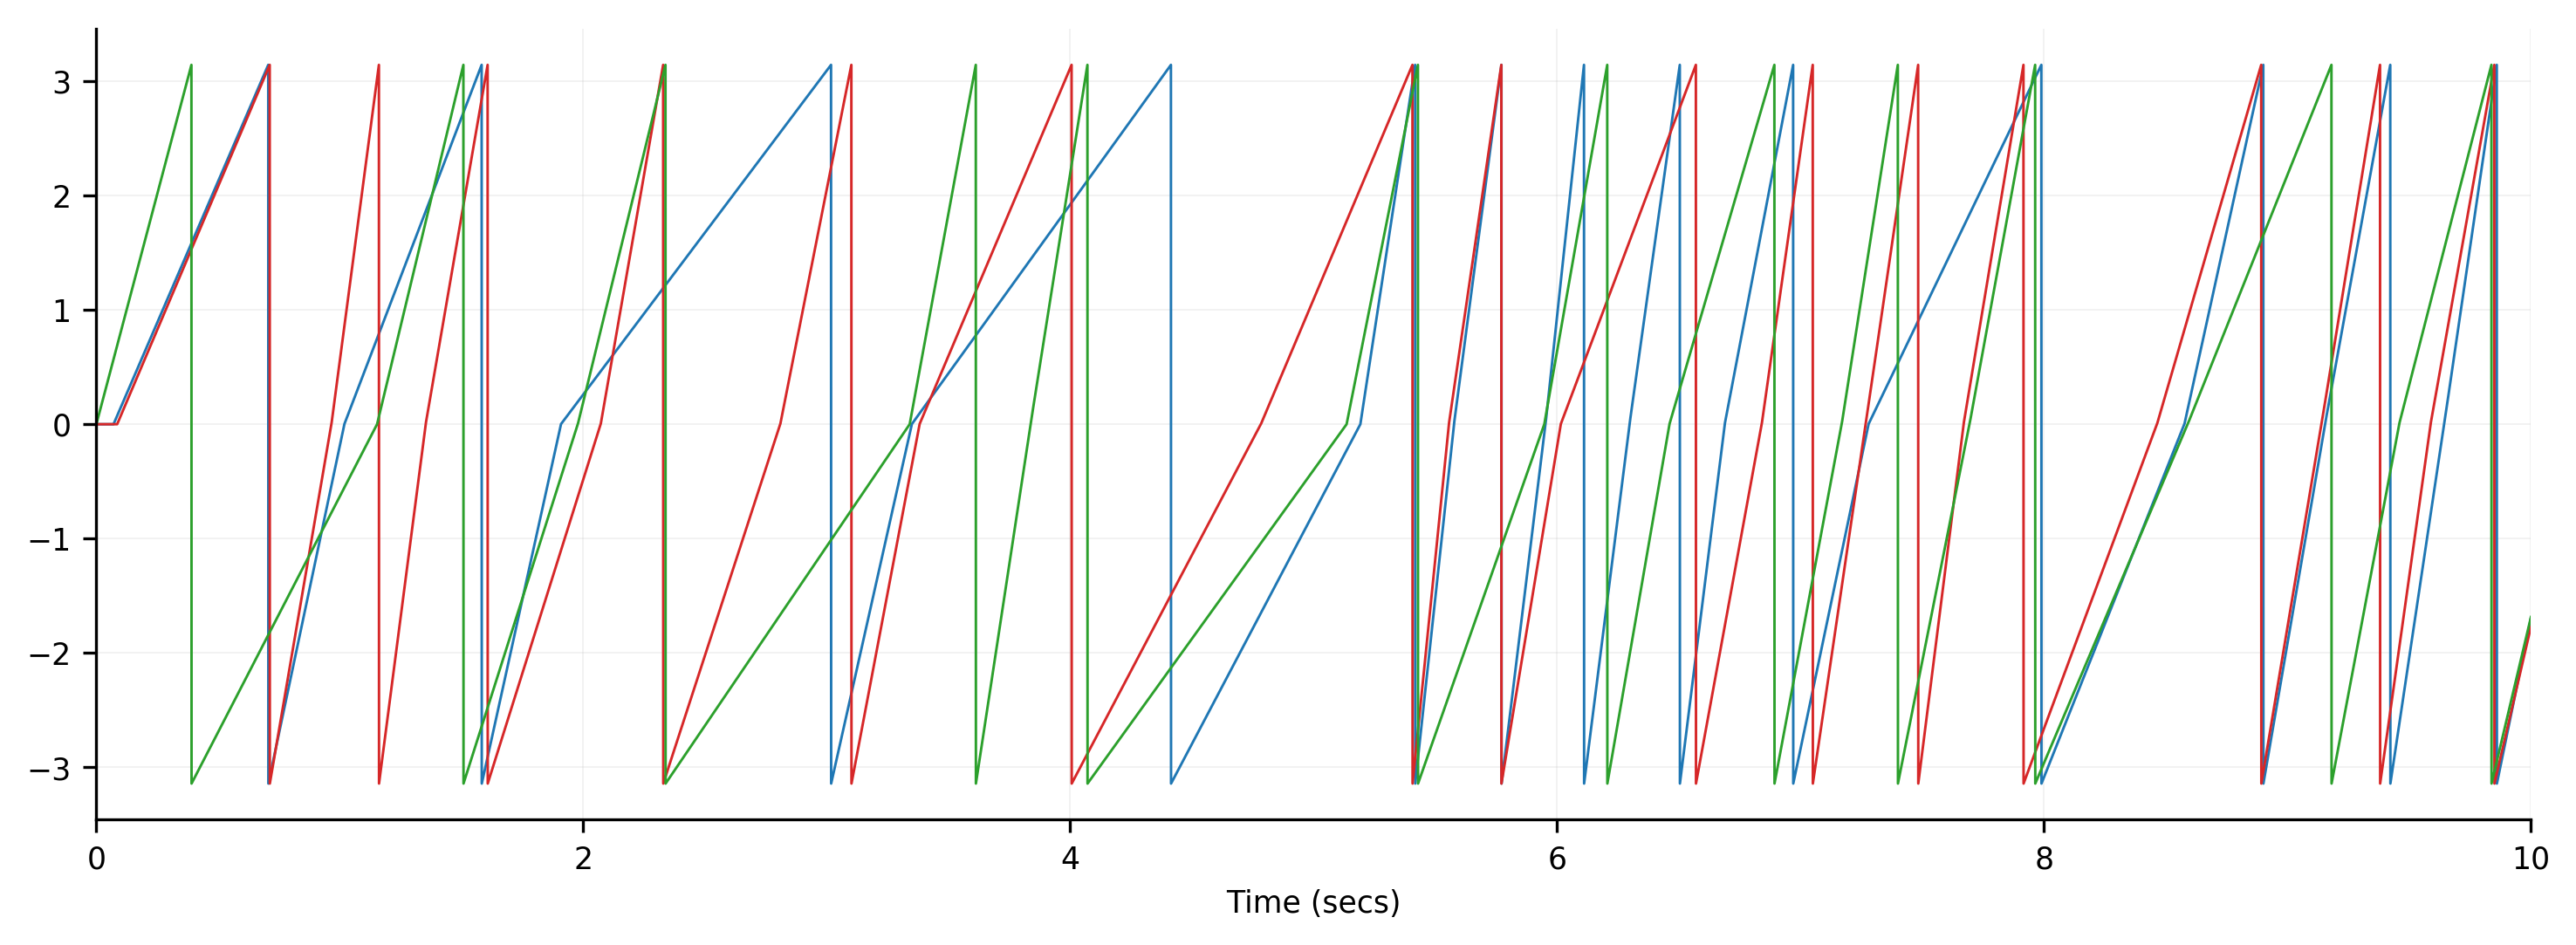

In [671]:
plot_trace(phase['sub_delta']['phase'][:3, :], start=0, duration=10)

In [522]:
reload(phase_locking)

<module 'phase_locking' from '/home1/dscho/code/projects/unit_activity_and_hpc_theta/phase_locking.py'>

In [502]:
upl_df_ = upl_df.copy()

In [523]:
start_time = time()

bands = OrderedDict([('sub_delta', [0.5, 2]),
                     ('delta', [1, 4]),
                     ('low_theta', [2, 8]),
                     ('high_theta', [4, 16]),
                     ('alpha_beta', [8, 32])])
upl_df = phase_locking.calc_phase_locking_fr_power_differences(subj_sess,
                                                               bands=bands, 
                                                               interp_spikes=False,
                                                               notch_freqs=[60, 120],
                                                               phase_type='extrema2',
                                                               hpc_subset=True,
                                                               n_bootstraps=1000,
                                                               save_outputs=False)

print('Done in {:.0f} secs'.format(time() - start_time))

Done in 1223 secs


In [516]:
upl_df_.iloc[:, 10:]

,pl_diffs_fr,pl_diffs_pow_locked,pl_diffs_pow_nonlocked,pl_diffs_fr_sign,pl_diffs_pow_locked_sign,pl_diffs_pow_nonlocked_sign,pl_diffs_fr_pval,pl_diffs_pow_locked_pval,pl_diffs_pow_nonlocked_pval,pl_diffs_fr_sig,pl_diffs_pow_locked_sig,pl_diffs_pow_nonlocked_sig
0,0.014003,0.045524,0.012645,1.0,1.0,1.0,0.549451,0.007992,0.486513,False,True,False
1,-0.032270,0.030303,0.004519,-1.0,1.0,1.0,0.008991,0.005994,0.457542,True,True,False
2,0.026436,0.108551,0.074395,1.0,1.0,1.0,0.073926,0.000999,0.000999,False,True,True
3,0.007618,0.076392,0.056916,1.0,1.0,1.0,0.649351,0.000999,0.000999,False,True,True
4,0.035909,0.238944,0.247810,1.0,1.0,1.0,0.354645,0.000999,0.000999,False,True,True
5,0.140351,0.295591,0.293519,1.0,1.0,1.0,0.026973,0.000999,0.000999,True,True,True
6,0.026297,0.022444,0.021399,1.0,1.0,1.0,0.018981,0.013986,0.061938,True,True,False
7,-0.014482,0.059189,0.048057,-1.0,1.0,1.0,0.244755,0.000999,0.000999,False,True,True
8,-0.025654,0.039927,0.012219,-1.0,1.0,1.0,0.236763,0.012987,0.210789,False,True,False
9,0.020037,0.016853,0.023271,1.0,1.0,1.0,0.402597,0.377622,0.050949,False,False,False


In [524]:
upl_df.iloc[:, 10:]

,pl_diffs_fr,pl_diffs_pow_locked,pl_diffs_pow_nonlocked,pl_diffs_fr_sign,pl_diffs_pow_locked_sign,pl_diffs_pow_nonlocked_sign,pl_diffs_fr_pval,pl_diffs_pow_locked_pval,pl_diffs_pow_nonlocked_pval,pl_diffs_fr_sig,pl_diffs_pow_locked_sig,pl_diffs_pow_nonlocked_sig
0,-0.001541,0.016366,-0.001121,-1.0,1.0,-1.0,0.948052,0.358641,0.955045,False,False,False
1,-0.000580,0.008493,0.001567,-1.0,1.0,1.0,0.960040,0.430569,0.810190,False,False,False
2,0.006284,0.006178,0.009938,1.0,1.0,1.0,0.672328,0.561439,0.407592,False,False,False
3,0.023362,-0.010472,0.011097,1.0,-1.0,1.0,0.165834,0.445554,0.333666,False,False,False
4,-0.044532,0.040121,-0.006662,-1.0,1.0,-1.0,0.223776,0.251748,0.773227,False,False,False
5,-0.065540,-0.063955,-0.040105,-1.0,-1.0,-1.0,0.256743,0.209790,0.229770,False,False,False
6,-0.002950,-0.001723,0.003170,-1.0,-1.0,1.0,0.776224,0.857143,0.842158,False,False,False
7,0.010589,-0.015794,0.010033,1.0,-1.0,1.0,0.390609,0.079920,0.445554,False,False,False
8,-0.004234,0.019792,0.011194,-1.0,1.0,1.0,0.841159,0.267732,0.227772,False,False,False
9,0.015361,-0.013432,0.002607,1.0,-1.0,1.0,0.494505,0.492507,0.832168,False,False,False


In [53]:
subj_sess = 'U390_ses3'
interp_spikes = False
notch_freqs = [60, 120]
phase_type = 'extrema2'
zscore_lfp=True
zscore_power=True
hpc_subset = True
n_bootstraps = 10
################

def calc_phase_locking_fr_power_differences(subj_sess,
                                            bands=None,
                                            interp_spikes=False,
                                            notch_freqs=[60, 120],
                                            zscore_lfp=True,
                                            zscore_power=True,
                                            phase_type='extrema2', 
                                            hpc_subset=True,
                                            n_bootstraps=1000,
                                            save_outputs=True,
                                            output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking'):
    """Calculate phase-locking between each unit and each channel LFP, 
    for a given set of frequency bands.
    
    Returns
    -------
    upl_df : pd.DataFrame
        The cross-electrode phase-locking DataFrame (all unit-to-LFP regional pairs).
    """

    # Get session info.
    subj_df = phase_locking.get_subj_df()

    # Load spikes.
    spikes, fr_df, clus_to_chan, chan_to_clus = phase_locking.load_spikes(subj_sess)
    units = fr_df.clus.tolist()

    # Load the raw LFP.
    ms_before = 2
    ms_after = 4
    lfp_raw, lfp_preproc = manning_analysis.process_lfp(subj_sess, 
                                                        subj_df=subj_df, 
                                                        notch_freqs=notch_freqs,
                                                        interpolate=interp_spikes,
                                                        session_spikes=spikes,
                                                        ms_before=ms_before,
                                                        ms_after=ms_after)
    del lfp_raw, spikes
    sampling_rate = lfp_preproc.samplerate.data.tolist()

    # Bandpass filter the LFP.
    lfp_filt = spp.filter_lfp_bands(lfp_preproc, 
                                    bands=bands, 
                                    zscore_lfp=zscore_lfp)

    # Use a derivative test to identify troughs and peaks in the filtered 
    # LFP, then linearly interpolate phase between cycles.
    phase = phase_locking.get_phase_bands(lfp_filt, 
                                          bands=bands, 
                                          find=phase_type, 
                                          lims=[-np.pi, np.pi])

    # Get Hilbert transform phase (instead of linearly interpolated phase).
    power = OrderedDict()
    for band_name, pass_band in bands.items():
        power[band_name], _ = spp.get_hilbert(lfp_filt[band_name], 
                                              zscore_power=zscore_power)
    del _

    # Load the cross-electrode DataFrame.
    pl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                         '{}_cross_electrode_unit_lfp_pairs_df.pkl'.format(subj_sess)))
    upl_df = dio.open_pickle(os.path.join('/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking',
                                          '{}_crosselec_phaselock_byunit_df_notch60-120_nospikeinterp_phase-extrema2_nomask_timelag-2to2sec-step10ms_1000bootstraps2_hpc-subset_bands--sub_delta0.5-2--delta1-4--low_theta2-8--high_theta4-16--alpha_beta8-32.pkl'.format(subj_sess)))
    pl_df = pd.merge(pl_df, upl_df[['subj_sess_unit', 'lfp_is_hpc', 'mrl_argmax', 'locked_band', 'sig']], 
                     how='inner', on=['subj_sess_unit', 'lfp_is_hpc'])
    del upl_df

    # Restrict analyses to a subset of pairs.
    if hpc_subset:
        # Remove inter-hemispheric pairs.
        pl_df = pl_df.loc[pl_df.same_hem==True]
        # Remove same-channel pairs.
        pl_df = pl_df.loc[pl_df.same_chan!=True]
        # Remove intra-regional pairs from different microwire bundles.
        pl_df = pl_df.query("(unit_roi2!=lfp_roi2) | ((unit_roi2==lfp_roi2) & (same_hemroi==True))")
        # Remove pairs that aren't intra-regional and where the LFP is extra-hippocampal.
        pl_df = pl_df.query("(lfp_is_hpc==True) | (unit_roi2==lfp_roi2)")
        # Remove units with <250 spikes.
        pl_df = pl_df.loc[pl_df.unit_nspikes>249]
        # Remove units that don't have connections to HPC.
        keep_units = pl_df.query("(lfp_is_hpc==True)").groupby(['subj_sess_unit']).size().index.tolist()
        pl_df = pl_df.query("(subj_sess_unit=={})".format(keep_units))
        # Remove insignificant units.
        pl_df = pl_df.query("(sig==True)")

    pl_df.reset_index(inplace=True, drop=True)

    # Get phase-locking differences between top and bottom quartiles
    # of spike phases, sorted by firing rate, power of the locked band,
    # and power of the remaining bands.
    pl_diffs = []
    bs_pl_diffs = []
    n_timepoints = len(fr_df.at[0, 'spikes'])
    bs_offsets_fr = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                              for _ in range(n_bootstraps)])
    bs_offsets_pow = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                               for _ in range(n_bootstraps)])
    for iunit in range(len(pl_df)):
        pl_diffs.append(get_pl_diffs_pair(iunit, pl_df, fr_df, offset=0))

        # Get bootstrap estimates by shuffling spike trains and recalculating values.
        bs_fr_vec = []
        bs_pow_locked_vec = []
        bs_pow_nonlocked_vec = []
        for iperm in range(n_bootstraps):
            bs_fr_vec.append(get_pl_diffs_pair(iunit, pl_df, fr_df, offset=bs_offsets_fr[iperm])['fr'])
            output = get_pl_diffs_pair(iunit, pl_df, fr_df, offset=bs_offsets_pow[iperm])
            bs_pow_locked_vec.append(output['pow_locked'])
            bs_pow_nonlocked_vec.append(output['pow_nonlocked'])
        bs_pl_diffs.append(OrderedDict([('fr', np.array(bs_fr_vec)),
                                        ('pow_locked', np.array(bs_pow_locked_vec)),
                                        ('pow_nonlocked', np.array(bs_pow_nonlocked_vec))]))

    # Append results to the phase-locking DataFrame.
    pl_df['pl_diffs_fr'] = [x['fr'] for x in pl_diffs]
    pl_df['pl_diffs_pow_locked'] = [x['pow_locked'] for x in pl_diffs]
    pl_df['pl_diffs_pow_nonlocked'] = [x['pow_nonlocked'] for x in pl_diffs]
    pl_df['bs_pl_diffs_fr'] = [x['fr'] for x in bs_pl_diffs]
    pl_df['bs_pl_diffs_pow_locked'] = [x['pow_locked'] for x in bs_pl_diffs]
    pl_df['bs_pl_diffs_pow_nonlocked'] = [x['pow_nonlocked'] for x in bs_pl_diffs]

    # Collapse the DataFrame into unit->LFP pairs for unit->local and unit->HPC 
    # connections, and determine significance vs. bootstrap estimates.
    alpha = 0.05
    upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 
                             'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                             'unit_fr', 'unit_nspikes'])
                   .agg({'pl_diffs_fr': np.mean,
                         'pl_diffs_pow_locked': np.mean,
                         'pl_diffs_pow_nonlocked': np.mean,
                         'bs_pl_diffs_fr': lambda x: tuple(np.mean(x)),
                         'bs_pl_diffs_pow_locked': lambda x: tuple(np.mean(x)),
                         'bs_pl_diffs_pow_nonlocked': lambda x: tuple(np.mean(x))})
                   .reset_index())
    upl_df['pl_diffs_fr_sign'] = upl_df.pl_diffs_fr.apply(np.sign)
    upl_df['pl_diffs_pow_locked_sign'] = upl_df.pl_diffs_pow_locked.apply(np.sign)
    upl_df['pl_diffs_pow_nonlocked_sign'] = upl_df.pl_diffs_pow_nonlocked.apply(np.sign)
    upl_df['bs_pl_diffs_fr'] = upl_df.bs_pl_diffs_fr.apply(lambda x: np.array(x))
    upl_df['bs_pl_diffs_pow_locked'] = upl_df.bs_pl_diffs_pow_locked.apply(lambda x: np.array(x))
    upl_df['bs_pl_diffs_pow_nonlocked'] = upl_df.bs_pl_diffs_pow_nonlocked.apply(lambda x: np.array(x))
    upl_df['pl_diffs_fr_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_fr']) >= 
                                                                    abs(x['pl_diffs_fr']))) / (1 + n_bootstraps), axis=1)
    upl_df['pl_diffs_pow_locked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_locked']) >= 
                                                                            abs(x['pl_diffs_pow_locked']))) / (1 + n_bootstraps), axis=1)
    upl_df['pl_diffs_pow_nonlocked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_nonlocked']) >= 
                                                                               abs(x['pl_diffs_pow_nonlocked']))) / (1 + n_bootstraps), axis=1)
    upl_df['pl_diffs_fr_sig'] = upl_df.pl_diffs_fr_pval < alpha
    upl_df['pl_diffs_pow_locked_sig'] = upl_df.pl_diffs_pow_locked_pval < alpha
    upl_df['pl_diffs_pow_nonlocked_sig'] = upl_df.pl_diffs_pow_nonlocked_pval < alpha
    upl_df = upl_df.loc[:, [col for col in upl_df.columns if col[:3] != 'bs_']]

    # Save the cross-electrode phase-locking DataFrame.
    process_str = ''
    process_str += 'notch' + '-'.join(str(i) for i in notch_freqs) if notch_freqs else 'nonotch'
    process_str += '_spikeinterp-{}to{}ms'.format(ms_before, ms_after) if interp_spikes else '_nospikeinterp'
    process_str += '_phase-{}'.format(phase_type)
    process_str += '_nomask'
    process_str += '_{}bootstraps2'.format(n_bootstraps)
    process_str += '_hpc-subset' if hpc_subset else ''
    process_str += '_bands--' + '--'.join(['{}{}-{}'.format(key, val[0], val[1]) for key, val in bands.items()])
    if save_outputs:
        fpath = os.path.join(output_dir, '{}_crosselec_phaselock_byunit_df_fr_power_diffs_{}.pkl'.format(subj_sess, process_str))
        dio.save_pickle(upl_df, fpath)

    return upl_df

In [429]:

pl_diffs = []
bs_pl_diffs = []
n_timepoints = len(fr_df.at[0, 'spikes'])
bs_offsets_fr = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                          for _ in range(n_bootstraps)])
bs_offsets_pow = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                           for _ in range(n_bootstraps)])
for iunit in range(len(pl_df)):
    pl_diffs.append(get_pl_diffs_pair(iunit, pl_df, fr_df, offset=0))
    
    bs_fr_vec = []
    bs_pow_locked_vec = []
    bs_pow_nonlocked_vec = []
    for iperm in range(n_bootstraps):
        bs_fr_vec.append(get_pl_diffs_pair(iunit, pl_df, fr_df, offset=bs_offsets_fr[iperm])['fr'])
        output = get_pl_diffs_pair(iunit, pl_df, fr_df, offset=bs_offsets_pow[iperm])
        bs_pow_locked_vec.append(output['pow_locked'])
        bs_pow_nonlocked_vec.append(output['pow_nonlocked'])
    bs_pl_diffs.append(OrderedDict([('fr', np.array(bs_fr_vec)),
                                    ('pow_locked', np.array(bs_pow_locked_vec)),
                                    ('pow_nonlocked', np.array(bs_pow_nonlocked_vec))]))
    
pl_df['pl_diffs_fr'] = [x['fr'] for x in pl_diffs]
pl_df['pl_diffs_pow_locked'] = [x['pow_locked'] for x in pl_diffs]
pl_df['pl_diffs_pow_nonlocked'] = [x['pow_nonlocked'] for x in pl_diffs]
pl_df['bs_pl_diffs_fr'] = [x['fr'] for x in bs_pl_diffs]
pl_df['bs_pl_diffs_pow_locked'] = [x['pow_locked'] for x in bs_pl_diffs]
pl_df['bs_pl_diffs_pow_nonlocked'] = [x['pow_nonlocked'] for x in bs_pl_diffs]

# Collapse the DataFrame into unit->LFP pairs for unit->local and unit->HPC 
# connections, and determine significance vs. bootstrap estimates.
alpha = 0.05
upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 
                         'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                         'unit_fr', 'unit_nspikes'])
               .agg({'pl_diffs_fr': np.mean,
                     'pl_diffs_pow_locked': np.mean,
                     'pl_diffs_pow_nonlocked': np.mean,
                     'bs_pl_diffs_fr': lambda x: tuple(np.mean(x)),
                     'bs_pl_diffs_pow_locked': lambda x: tuple(np.mean(x)),
                     'bs_pl_diffs_pow_nonlocked': lambda x: tuple(np.mean(x))})
               .reset_index())
upl_df['pl_diffs_fr_sign'] = upl_df.pl_diffs_fr.apply(np.sign)
upl_df['pl_diffs_pow_locked_sign'] = upl_df.pl_diffs_pow_locked.apply(np.sign)
upl_df['pl_diffs_pow_nonlocked_sign'] = upl_df.pl_diffs_pow_nonlocked.apply(np.sign)
upl_df['bs_pl_diffs_fr'] = upl_df.bs_pl_diffs_fr.apply(lambda x: np.array(x))
upl_df['bs_pl_diffs_pow_locked'] = upl_df.bs_pl_diffs_pow_locked.apply(lambda x: np.array(x))
upl_df['bs_pl_diffs_pow_nonlocked'] = upl_df.bs_pl_diffs_pow_nonlocked.apply(lambda x: np.array(x))
upl_df['pl_diffs_fr_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_fr']) >= 
                                                                abs(x['pl_diffs_fr']))) / (1 + n_bootstraps), axis=1)
upl_df['pl_diffs_pow_locked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_locked']) >= 
                                                                        abs(x['pl_diffs_pow_locked']))) / (1 + n_bootstraps), axis=1)
upl_df['pl_diffs_pow_nonlocked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_nonlocked']) >= 
                                                                           abs(x['pl_diffs_pow_nonlocked']))) / (1 + n_bootstraps), axis=1)
upl_df['pl_diffs_fr_sig'] = upl_df.pl_diffs_fr_pval < alpha
upl_df['pl_diffs_pow_locked_sig'] = upl_df.pl_diffs_pow_locked_pval < alpha
upl_df['pl_diffs_pow_nonlocked_sig'] = upl_df.pl_diffs_pow_nonlocked_pval < alpha

upl_df = upl_df.loc[:, [col for col in upl_df.columns if col[:3] != 'bs_']]

print('Done in {:.0f} secs'.format(time() - start_time))

Done in 10 secs


In [341]:
pl_df[['subj_sess_unit', 'unit', 'unit_chan_ind', 'unit_hemroi2', 'lfp_chan_ind', 'lfp_hemroi2']].head()

,subj_sess_unit,unit,unit_chan_ind,unit_hemroi2,lfp_chan_ind,lfp_hemroi2
0,U390_ses3_4,4,6,rhpc,0,rhpc
1,U390_ses3_4,4,6,rhpc,1,rhpc
2,U390_ses3_4,4,6,rhpc,2,rhpc
3,U390_ses3_4,4,6,rhpc,3,rhpc
4,U390_ses3_4,4,6,rhpc,4,rhpc


In [342]:
pl_df.loc[pl_df.unit==18]

,subj_sess,subj_sess_unit,unit,unit_chan,unit_chan_ind,unit_hemroi,unit_hem,unit_roi,unit_is_hpc,unit_nspikes,...,same_roi,both_hpc,unit_hemroi2,lfp_hemroi2,unit_roi2,lfp_roi2,same_roi2,mrl_argmax,locked_band,sig
94,U390_ses3,U390_ses3_18,18,32,31,LAH,L,AH,1,252,...,1,1,lhpc,lhpc,hpc,hpc,True,0,sub_delta,True
95,U390_ses3,U390_ses3_18,18,32,31,LAH,L,AH,1,252,...,1,1,lhpc,lhpc,hpc,hpc,True,0,sub_delta,True
96,U390_ses3,U390_ses3_18,18,32,31,LAH,L,AH,1,252,...,1,1,lhpc,lhpc,hpc,hpc,True,0,sub_delta,True
97,U390_ses3,U390_ses3_18,18,32,31,LAH,L,AH,1,252,...,1,1,lhpc,lhpc,hpc,hpc,True,0,sub_delta,True
98,U390_ses3,U390_ses3_18,18,32,31,LAH,L,AH,1,252,...,1,1,lhpc,lhpc,hpc,hpc,True,0,sub_delta,True
99,U390_ses3,U390_ses3_18,18,32,31,LAH,L,AH,1,252,...,1,1,lhpc,lhpc,hpc,hpc,True,0,sub_delta,True
100,U390_ses3,U390_ses3_18,18,32,31,LAH,L,AH,1,252,...,1,1,lhpc,lhpc,hpc,hpc,True,0,sub_delta,True


In [426]:
def get_pl_diffs_pair(iunit, pl_df, fr_df, offset=0):
    """Return top vs. bottom quartile differences in phase-locking
    strength (MRL) for spike phases in the phase-locked band that 
    are sorted by 1) firing rate, 2) power in the phase-locked band, 
    and 3) power in the remaining bands.
    """
    unit = pl_df.at[iunit, 'unit']
    lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
    locked_band_ind = pl_df.at[iunit, 'mrl_argmax']
    locked_band = pl_df.at[iunit, 'locked_band']
    fr = fr_df.at[unit, 'fr']
    spike_train = fr_df.at[unit, 'spikes']
    if offset:
        spike_train = np.roll(spike_train, offset)
    spike_inds = np.where(spike_train)[0]
    qtl = int(len(spike_inds) / 4)

    # Sort spikes by 1) firing rate of the neuron, and 2) power in each band. 
    xsort = OrderedDict()
    xsort['fr'] = fr[spike_inds].argsort()
    for band_name in band_names:
        xsort[band_name] = power[band_name][lfp_chan_ind, spike_inds].argsort()

    # Get spike phases for the phase-locked band, sorted by 1) firing rate, and 2) power in each band.
    spike_phases = OrderedDict()
    spike_phases_ = phase[locked_band]['phase'][lfp_chan_ind, spike_inds]
    spike_phases['fr'] = spike_phases_[xsort['fr']]
    for band_name in band_names:
        spike_phases['pow_' + band_name] = spike_phases_[xsort[band_name]]

    # Get the difference in MRL for spike phases in the top vs. bottom quartile of 1) firing rate,
    # 2) power in the locked band, and 3) power in all remaining bands (mean MRL difference).
    pl_diffs = OrderedDict()
    pl_diffs['fr'] = (circstats.circmoment(spike_phases['fr'][-qtl:])[1] - 
                      circstats.circmoment(spike_phases['fr'][:qtl])[1])
    pl_diffs['pow_locked'] = (circstats.circmoment(spike_phases['pow_' + locked_band][-qtl:])[1] - 
                              circstats.circmoment(spike_phases['pow_' + locked_band][:qtl])[1])
    nonlocked_bands = [x for x in band_names if x not in [locked_band]]
    nonlocked_pl_diffs = []
    for band_name in nonlocked_bands:
        nonlocked_pl_diffs.append((circstats.circmoment(spike_phases['pow_' + band_name][-qtl:])[1] - 
                                   circstats.circmoment(spike_phases['pow_' + band_name][:qtl])[1]))
    pl_diffs['pow_nonlocked'] = np.mean(nonlocked_pl_diffs)
    
    return pl_diffs

In [455]:
get_pl_diffs_pair(iunit, pl_df, fr_df, offset=0)

OrderedDict([('fr', 0.26333595148854866),
             ('pow_locked', 0.48716004116755784),
             ('pow_nonlocked', 0.3743040642480237)])

In [453]:
# Get the mean MRL across unit->LFP pairs for unit->local
# and unit->HPC connections, for each band.
alpha = 0.05
upl_df = (pl_df.groupby(['subj_sess_unit', 'subj_sess', 'unit_roi2', 'lfp_roi2', 
                         'unit_hem', 'lfp_hem', 'unit_is_hpc', 'lfp_is_hpc', 
                         'unit_fr', 'unit_nspikes'])
               .agg({'pl_diffs_fr': np.mean,
                     'pl_diffs_pow_locked': np.mean,
                     'pl_diffs_pow_nonlocked': np.mean,
                     'bs_pl_diffs_fr': lambda x: tuple(np.mean(x)),
                     'bs_pl_diffs_pow_locked': lambda x: tuple(np.mean(x)),
                     'bs_pl_diffs_pow_nonlocked': lambda x: tuple(np.mean(x))})
               .reset_index())
upl_df['pl_diffs_fr_sign'] = upl_df.pl_diffs_fr.apply(np.sign)
upl_df['pl_diffs_pow_locked_sign'] = upl_df.pl_diffs_pow_locked.apply(np.sign)
upl_df['pl_diffs_pow_nonlocked_sign'] = upl_df.pl_diffs_pow_nonlocked.apply(np.sign)
upl_df['bs_pl_diffs_fr'] = upl_df.bs_pl_diffs_fr.apply(lambda x: np.array(x))
upl_df['bs_pl_diffs_pow_locked'] = upl_df.bs_pl_diffs_pow_locked.apply(lambda x: np.array(x))
upl_df['bs_pl_diffs_pow_nonlocked'] = upl_df.bs_pl_diffs_pow_nonlocked.apply(lambda x: np.array(x))
upl_df['pl_diffs_fr_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_fr']) >= 
                                                                abs(x['pl_diffs_fr']))) / (1 + n_bootstraps), axis=1)
upl_df['pl_diffs_pow_locked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_locked']) >= 
                                                                        abs(x['pl_diffs_pow_locked']))) / (1 + n_bootstraps), axis=1)
upl_df['pl_diffs_pow_nonlocked_pval'] = upl_df.apply(lambda x: (1 + np.sum(abs(x['bs_pl_diffs_pow_nonlocked']) >= 
                                                                           abs(x['pl_diffs_pow_nonlocked']))) / (1 + n_bootstraps), axis=1)
upl_df['pl_diffs_fr_sig'] = upl_df.pl_diffs_fr_pval < alpha
upl_df['pl_diffs_pow_locked_sig'] = upl_df.pl_diffs_pow_locked_pval < alpha
upl_df['pl_diffs_pow_nonlocked_sig'] = upl_df.pl_diffs_pow_nonlocked_pval < alpha

upl_df = upl_df.loc[:, [col for col in upl_df.columns if col[:3] != 'bs_']]

In [454]:
upl_df

,subj_sess_unit,subj_sess,unit_roi2,lfp_roi2,unit_hem,lfp_hem,unit_is_hpc,lfp_is_hpc,unit_fr,unit_nspikes,...,pl_diffs_pow_nonlocked,pl_diffs_fr_sign,pl_diffs_pow_locked_sign,pl_diffs_pow_nonlocked_sign,pl_diffs_fr_pval,pl_diffs_pow_locked_pval,pl_diffs_pow_nonlocked_pval,pl_diffs_fr_sig,pl_diffs_pow_locked_sig,pl_diffs_pow_nonlocked_sig
0,U390_ses3_10,U390_ses3,phg,phg,R,R,0,0,2.572700,3018,...,0.012645,1.0,1.0,1.0,0.545455,0.090909,0.727273,False,False,False
1,U390_ses3_11,U390_ses3,phg,phg,R,R,0,0,3.528299,4139,...,0.004519,-1.0,1.0,1.0,0.090909,0.090909,0.727273,False,False,False
2,U390_ses3_13,U390_ses3,hpc,hpc,L,L,1,1,9.029172,10592,...,0.074395,1.0,1.0,1.0,0.090909,0.090909,0.090909,False,False,False
3,U390_ses3_16,U390_ses3,hpc,hpc,L,L,1,1,1.908640,2239,...,0.056916,1.0,1.0,1.0,0.545455,0.090909,0.090909,False,False,False
4,U390_ses3_17,U390_ses3,hpc,hpc,L,L,1,1,0.638487,749,...,0.247810,1.0,1.0,1.0,0.363636,0.090909,0.090909,False,False,False
5,U390_ses3_18,U390_ses3,hpc,hpc,L,L,1,1,0.214818,252,...,0.293519,1.0,1.0,1.0,0.090909,0.090909,0.090909,False,False,False
6,U390_ses3_4,U390_ses3,hpc,hpc,R,R,1,1,4.536750,5322,...,0.021399,1.0,1.0,1.0,0.090909,0.090909,0.090909,False,False,False
7,U390_ses3_5,U390_ses3,hpc,hpc,R,R,1,1,6.503357,7629,...,0.048057,-1.0,1.0,1.0,0.181818,0.090909,0.090909,False,False,False
8,U390_ses3_7,U390_ses3,phg,hpc,R,R,0,1,1.565102,1836,...,0.012219,-1.0,1.0,1.0,0.181818,0.181818,0.272727,False,False,False
9,U390_ses3_7,U390_ses3,phg,phg,R,R,0,0,1.565102,1836,...,0.023271,1.0,1.0,1.0,0.454545,0.363636,0.181818,False,False,False


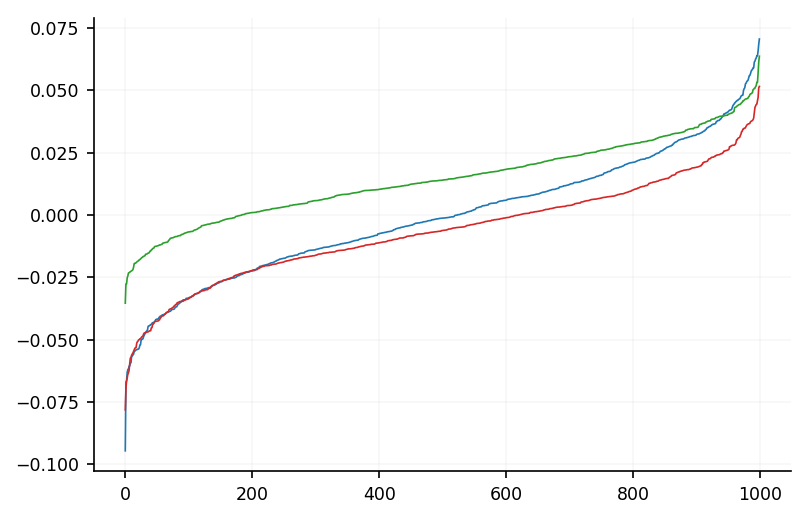

In [425]:
plt.plot(np.sort(bs_pl_diffs[0]['fr']))
plt.plot(np.sort(bs_pl_diffs[0]['pow_locked']))
plt.plot(np.sort(bs_pl_diffs[0]['pow_nonlocked']))

In [378]:
# Is the magnitude of the difference in MRL for spike phases in the
# bottom vs. top quarter of firing rates greater than would be expected
# by chance? (If so, is phase-locking stronger during periods of low or 
# high firing rate?)
n_bootstraps = 1000
output = []
for iunit in range(len(pl_df)):
    unit = pl_df.at[iunit, 'unit']
    lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
    locked_band_ind = pl_df.at[iunit, 'mrl_argmax']
    locked_band = pl_df.at[iunit, 'locked_band']
    spike_train = fr_df.at[unit, 'spikes']
    fr = fr_df.at[unit, 'fr']
    spike_inds = np.where(spike_train)[0]
    qtl = int(len(spike_inds) / 4)

    # Sort spikes by 1) firing rate of the neuron, and 2) power in each band. 
    xsort = OrderedDict()
    xsort['fr'] = fr[spike_inds].argsort()
    for band_name in band_names:
        xsort[band_name] = power[band_name][lfp_chan_ind, spike_inds].argsort()

    # Get spike phases for the phase-locked band, sorted by 1) firing rate, and 2) power in each band.
    spike_phases = OrderedDict()
    spike_phases['fr'] = phase[locked_band]['phase'][lfp_chan_ind, spike_inds][xsort['fr']]
    for band_name in band_names:
        spike_phases['pow_' + band_name] = phase[locked_band]['phase'][lfp_chan_ind, spike_inds][xsort[band_name]]

    # Get the difference in MRL for spike phases in the top vs. bottom quartile of 1) firing rate,
    # 2) power in the locked band, and 3) power in all remaining bands (mean MRL difference).
    pl_diffs = OrderedDict()
    pl_diffs['fr'] = (circstats.circmoment(spike_phases['fr'][-qtl:])[1] - 
                      circstats.circmoment(spike_phases['fr'][:qtl])[1])
    pl_diffs['pow_locked'] = (circstats.circmoment(spike_phases['pow_' + locked_band][-qtl:])[1] - 
                              circstats.circmoment(spike_phases['pow_' + locked_band][:qtl])[1])
    nonlocked_bands = [x for x in band_names if x not in [locked_band]]
    nonlocked_pl_diffs = []
    for band_name in nonlocked_bands:
        nonlocked_pl_diffs.append((circstats.circmoment(spike_phases['pow_' + band_name][-qtl:])[1] - 
                                   circstats.circmoment(spike_phases['pow_' + band_name][:qtl])[1]))
    pl_diffs['pow_nonlocked'] = np.mean(nonlocked_pl_diffs)
    
    output.append(pl_diffs)
    
    # Bootstrap testing.
    
    
    
    # Bootstrapping - Randomly shift the spike train n_bootstraps times and
    # recalc MRLs. Because a unit could be phase-locked at a short time
    # lag, permutations will shift the spike train by at least 2 secs.
    # IMPORTANTLY, each permutation shifts all spike trains by the same offset. 
    bs_mrls = []
    n_timepoints = len(spike_train)
    bs_offsets = np.array([4000+int(random.random() * (n_timepoints-4001)) 
                           for _ in range(n_bootstraps)])
    for iunit in range(len(pl_df)):
        unit = pl_df.at[iunit, 'unit']
        lfp_chan_ind = pl_df.at[iunit, 'lfp_chan_ind']
        spike_train = fr_df.at[unit, 'spikes']
        unit_bs_mrls = []
        for band_name, pass_band in bands.items(): 
            unit_bs_mrls_ = []
            for iperm in range(n_bootstraps):
                spike_train_shifted = np.roll(spike_train, bs_offsets[iperm])
                spike_train_shifted[:4000] = False
                spike_train_shifted[-4000:] = False
                if mask_type is None:
                    spike_inds = np.where(spike_train_shifted)[0]
                else:
                    spike_inds = np.where(mask[band_name][lfp_chan_ind, :] * spike_train_shifted)[0]
                spike_phases = phase[band_name]['phase'][lfp_chan_ind, spike_inds]
                unit_bs_mrls_.append(circstats.circmoment(spike_phases)[1])
            unit_bs_mrls.append(unit_bs_mrls_)
        bs_mrls.append(np.array(unit_bs_mrls))
    pl_df['bs_mrls'] = bs_mrls
    del phase
    
# pl_diff = circstats.circmoment(spike_phases['fr'][-qtl:])[1] - circstats.circmoment(spike_phases['fr'][:qtl])[1]

# bs_pl_diffs = []
# for iperm in range(n_bootstraps):
#     np.random.shuffle(spike_phases)
#     bs_pl_diffs.append(circstats.circmoment(spike_phases[-qtl:])[1] - circstats.circmoment(spike_phases[:qtl])[1])

# pval = (1 + np.sum(np.abs(bs_pl_diffs) >= np.abs(pl_diff))) / (1 + n_bootstraps)

In [394]:
fr_output = np.array([x['fr'] for x in output])
pow_locked_output = np.array([x['pow_locked'] for x in output])
pow_nonlocked_output = np.array([x['pow_nonlocked'] for x in output])

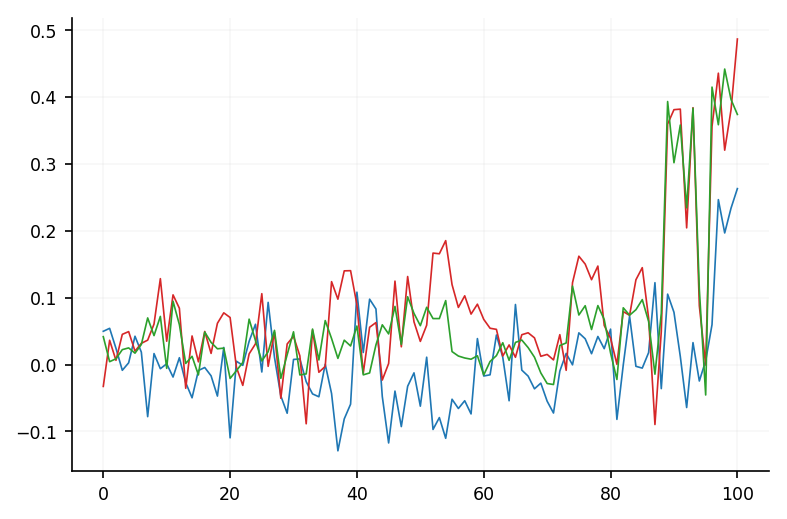

In [386]:
plt.plot(fr_output)
plt.plot(pow_locked_output)
plt.plot(pow_nonlocked_output)

In [369]:
pl_diffs

OrderedDict([('fr', -0.02448598123683879),
             ('pow_locked', 0.08800968381783236),
             ('pow_nonlocked', 0.11273607238389993)])

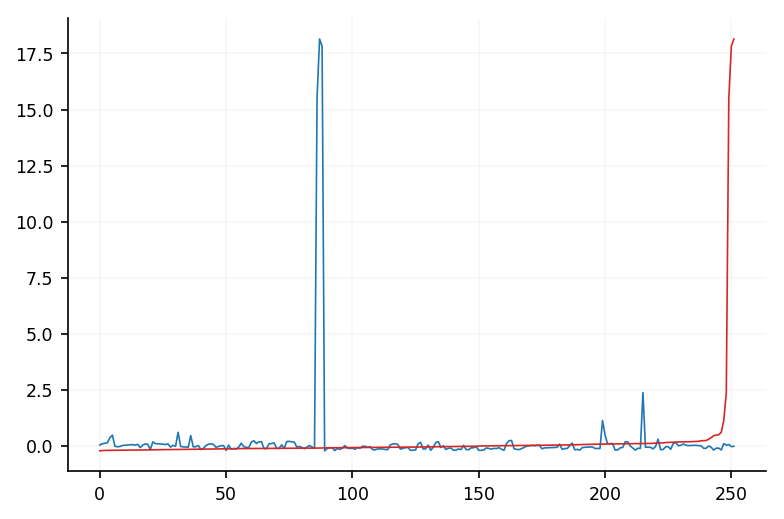

In [303]:
plt.plot(power[band_name][lfp_chan_ind, spike_inds])
plt.plot(power[band_name][lfp_chan_ind, spike_inds][power[band_name][lfp_chan_ind, spike_inds].argsort()])

In [6]:
phase_locking.calc_cross_electrode_phase_locking_mrl??

Signature: phase_locking.calc_cross_electrode_phase_locking_mrl(subj_sess, bands=None, interp_spikes=True, notch_freqs=[60, 120], zscore_lfp=True, zscore_power=True, phase_type='peaks', power_percentile=25, osc_length=3, mask_type=None, hpc_subset=False, n_bootstraps=1000, save_outputs=True, output_dir='/scratch/dscho/unit_activity_and_hpc_theta/data/crosselec_phase_locking')
Source:   
def calc_cross_electrode_phase_locking_mrl(subj_sess,
                                           bands=None,
                                           interp_spikes=True,
                                           notch_freqs=[60, 120],
                                           zscore_lfp=True,
                                           zscore_power=True,
                                           phase_type='peaks', # troughs, peaks, or hilbert
                                           power_percentile=25,
                                           osc_length=3,
                                     

In [274]:
pval

0.1878121878121878

In [255]:
pl_diff

0.08385927833477907

In [250]:
np.array_equal(fr[spike_inds].argsort(), xsort)

True

In [238]:
circstats.circmoment(spike_phases), circstats.rayleightest(spike_phases)

((2.2971232139824624, 0.3656934971854504), 2.312616242601409e-15)

In [229]:
stats.pearsonr(np.arange(5), np.array([circstats.circmoment(x)[1] for x in np.split(spike_phases, 5)]))

(0.5718810014594635, 0.31376723863258715)

In [218]:
np.arange(5) + (np.random.rand(5)-0.5)

array([-0.28984281,  1.136301  ,  1.59507673,  2.72464382,  4.25819685])

In [228]:
stats.pearsonr(np.arange(5), np.arange(5) + (np.random.rand(5)-0.5))

(0.990117981146252, 0.0011774909316903785)

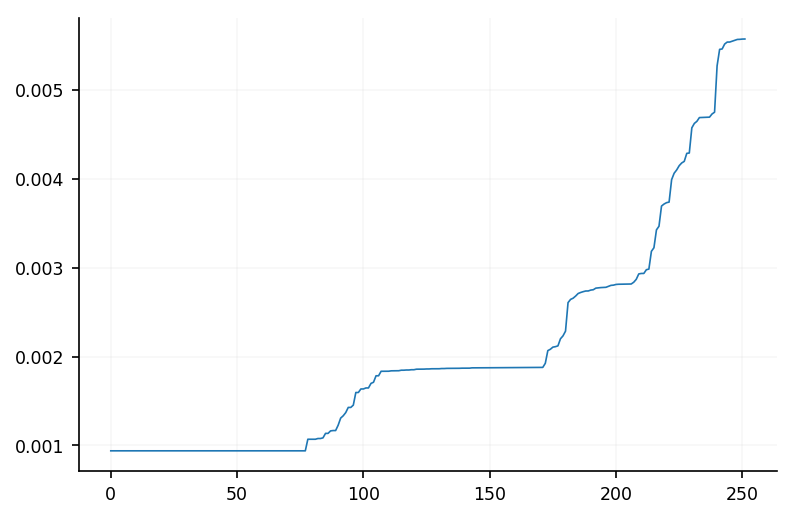

In [86]:
plt.plot(spike_fr[xsort])

(<Figure size 3600x1200 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b5c2f3f9eb8>],
       dtype=object))

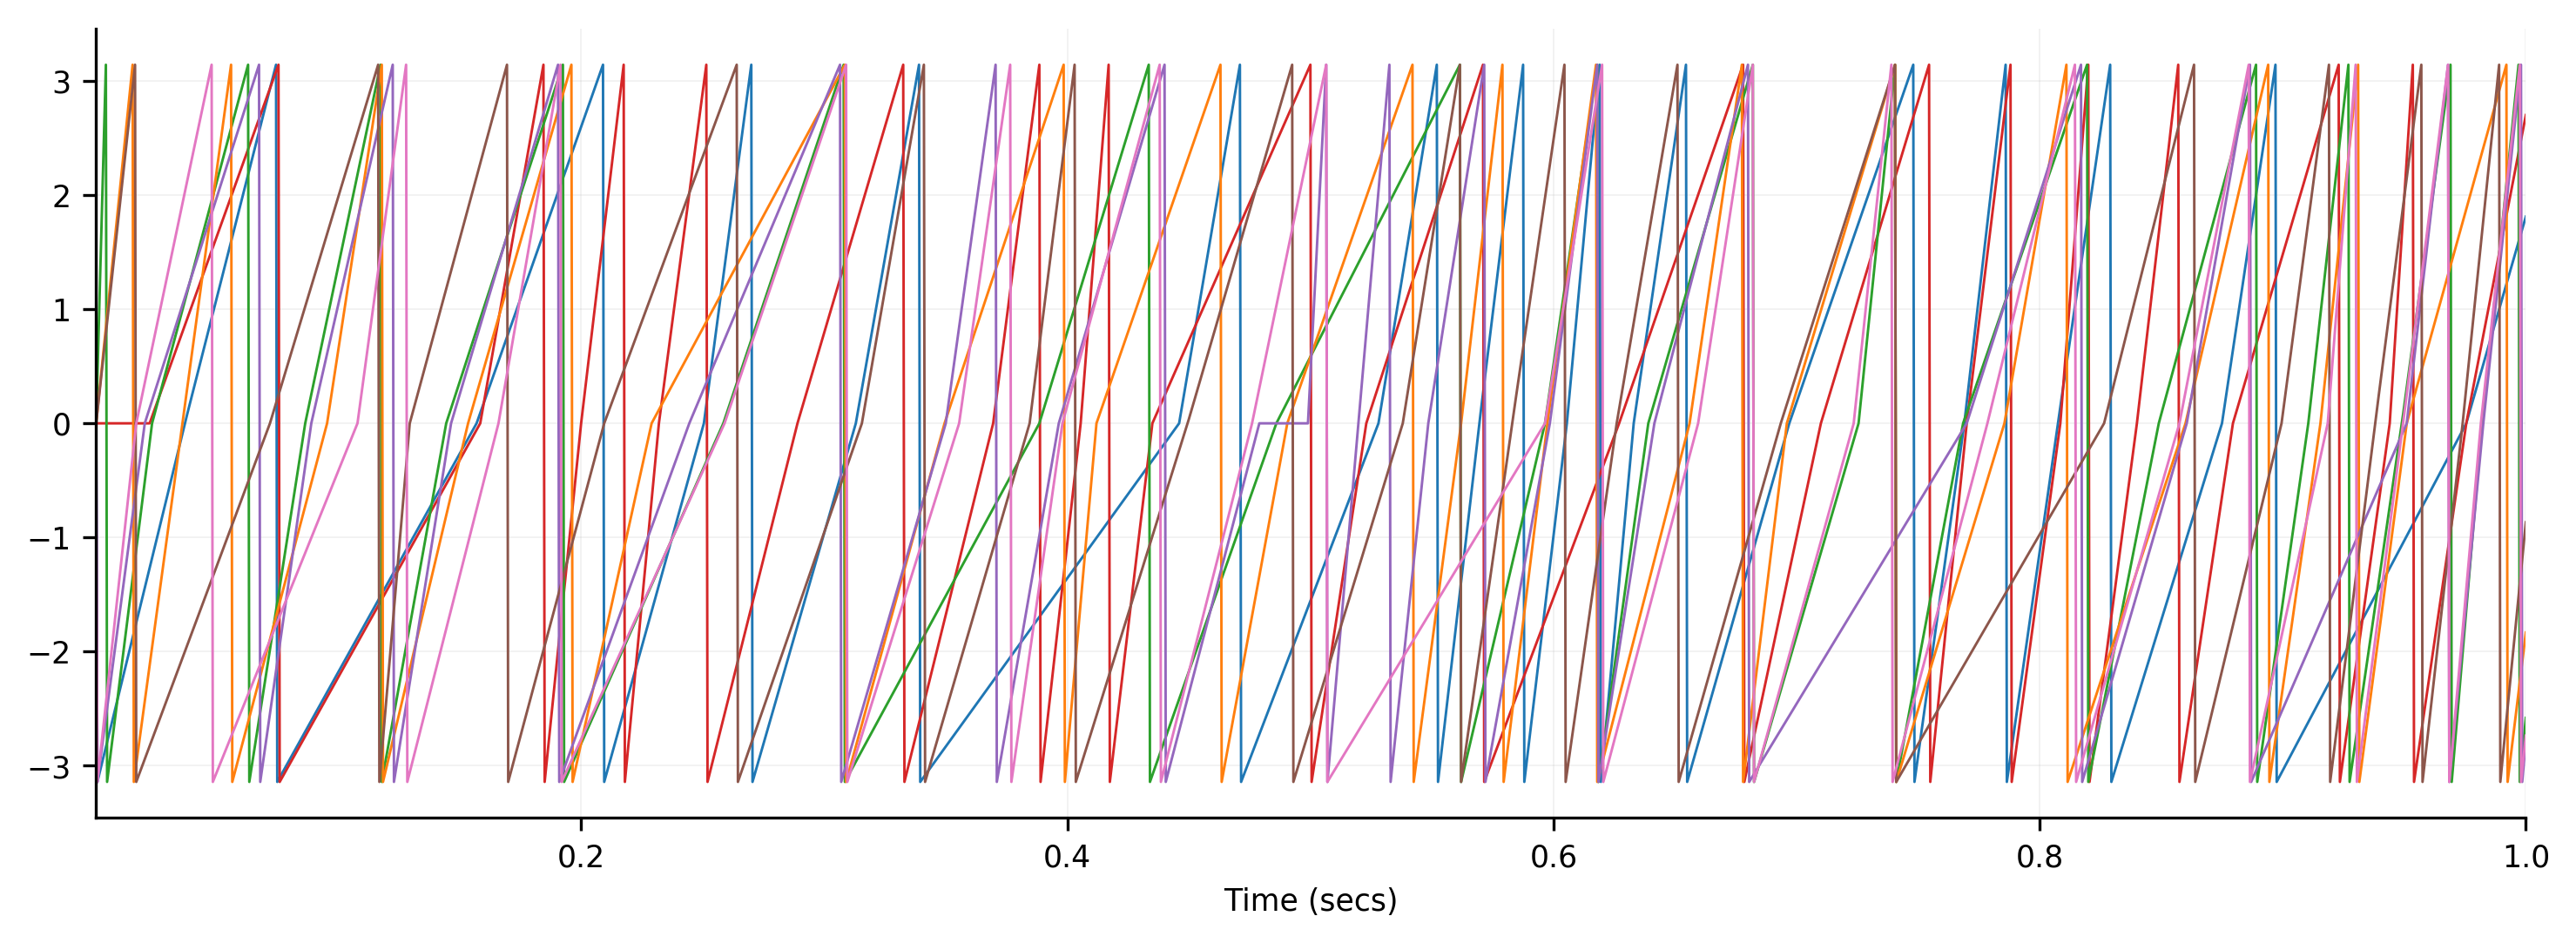

In [85]:
plot_trace(phase['alpha_beta']['phase'][24:31, :], start=0, duration=1)

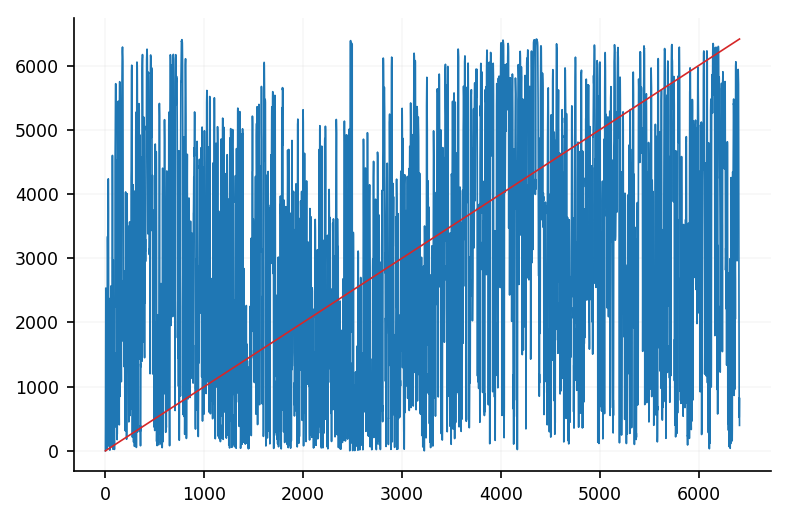

In [51]:
xsort = spike_fr.argsort()

spike_fr_ranks = np.empty(xsort.shape)
spike_fr_ranks[xsort] = np.arange(len(spike_fr_ranks))

plt.plot(spike_fr_ranks)
plt.plot(np.sort(spike_fr_ranks))

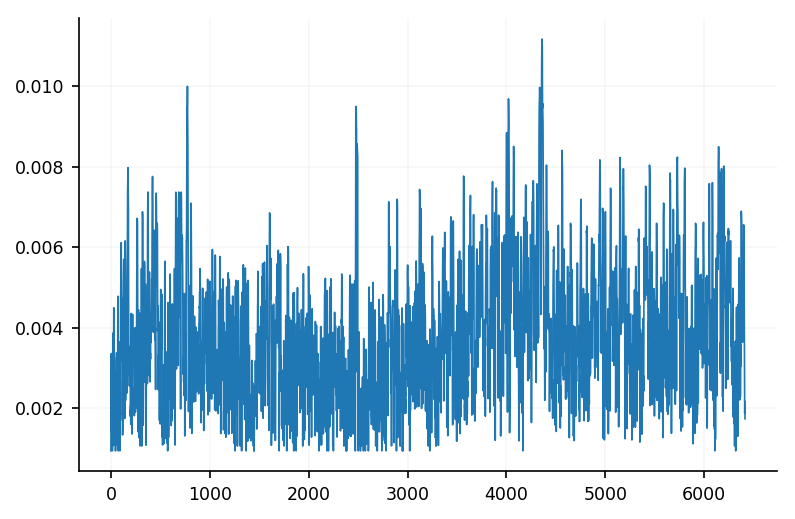

In [50]:
plt.plot(spike_fr)